In [20]:
import numpy as np
import faiss
import time
from vasili_helpers import *
from tqdm import tqdm

# NOTE: I copied code here instead of importing
# from faiss.contrib.inspect_tools import get_invlist
# from faiss.contrib.ivf_tools import replace_ivf_quantizer, add_preassigned
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
# InteractiveShell.ast_node_interactivity = "last"

%load_ext autoreload
%autoreload 2


from CrackIVF import *
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
ANN_DATASETS = [
    "deep-image-96-angular",
    "glove-25-angular",
    "glove-50-angular",
    "glove-100-angular",
    "sift-128-euclidean",
    "lastfm-64-dot",
]

In [ ]:
dbname = "sift-128-euclidean"
# dbname = "SIFT10M"
# dbname = "deep-image-96-angular"
# xb, xq, gt, metric = load_dataset("SIFT1M")
xb, xq, gt, metric = load_dataset(dbname)
NUM_THREADS = 16
faiss.omp_set_num_threads(NUM_THREADS)

# nlist = 10000
# real_crack_index = CrackIVF(
#     nlist=nlist, 
#     niter=0,
#     max_pts=256, # faiss default
#     seed=1,
#     metric=metric
# )
# real_crack_index.add(xb) # add 1M points

Loading Dataset = sift-128-euclidean
File already exists at /pub/scratch/vmageirakos/vdb-project-data/data/datasets/sift-128-euclidean.hdf5. Skipping download.


In [22]:
def fit_and_evaluate_model(X_data, y_data):
    """
    Fits a linear regression model to the input data and evaluates it using Mean Absolute Error (MAE).
    
    Args:
    - X_data (numpy array): Input features (shape: num_samples x num_features)
    - y_data (numpy array): Target variable (shape: num_samples,)
    
    Returns:
    - w1 (float): Coefficient for X1
    - w2 (float): Coefficient for X2
    - b (float): Intercept
    - mae (float): Mean Absolute Error (MAE)
    """
    # Step 1: Initialize the Linear Regression model
    model = LinearRegression()

    # Step 2: Train the model on the collected data
    model.fit(X_data, y_data)

    # Step 3: Get the fitted coefficients (w1, w2) and intercept (b)
    w1, w2 = model.coef_
    b = model.intercept_

    # Step 4: Make predictions based on the input data
    y_pred = model.predict(X_data)

    # Step 5: Evaluate the model using Mean Absolute Error (MAE)
    mae = mean_absolute_error(y_data, y_pred)
    print(f"Fitted model: T = w1 * X1 + w2 * X2 + b")
    print(f"w1 = {w1}, w2 = {w2}, b = {b}")
    print(f"Mean Absolute Error (MAE): {mae} ms")

    # Step 6: Visualize the results (Measured vs Predicted Latency)
    plt.figure(figsize=(8, 6))
    plt.scatter(y_data, y_pred, label="Measured vs Predicted", color='blue')
    plt.plot([min(y_data), max(y_data)], [min(y_data), max(y_data)], color='red', linestyle='--')
    plt.xlabel("Measured Latency (ms)")
    plt.ylabel("Predicted Latency (ms)")
    plt.title("Measured vs Predicted Latency")
    plt.legend()
    plt.show()

    y_pred = model.predict(X_data)
    mse = mean_squared_error(y_data, y_pred)
    rmse = np.sqrt(mse)
    print("MSE (in ms^2):", mse)
    print("RMSE (in ms):", rmse)
    r2 = r2_score(y_data, y_pred)
    print("R2 Score:", r2)

    return w1, w2, b, mae, model # make sure you return the model....


def fit_and_evaluate_second_order_model(X_data, y_data, model_type="linear", degree=2):
    """
    Fits a regression model (linear or polynomial) to the input data and evaluates it using Mean Absolute Error (MAE).
    
    Args:
    - X_data (numpy array): Input features (shape: num_samples x num_features)
    - y_data (numpy array): Target variable (shape: num_samples,)
    - model_type (str): Type of model ("linear", "polynomial", "log", "interaction")
    - degree (int): Degree for polynomial regression
    
    Returns:
    - model: Trained regression model
    - mae (float): Mean Absolute Error (MAE)
    """
    
    # Step 1: Transform X_data based on the chosen model
    if model_type == "polynomial":
        # NOTE: this works fine for init cents?
        poly = PolynomialFeatures(degree=degree, include_bias=False)
        X_data = poly.fit_transform(X_data)
        # for degree = 2 it expands X1,X2 to X1,X2,X1^2,X2^2,X1X2, to capture non-linear effects

    elif model_type == "log":
        X_data = np.log1p(X_data)  # log(1 + X) to avoid log(0)

    elif model_type == "interaction":
        X1, X2 = X_data[:, 0], X_data[:, 1]
        X_data = np.column_stack((X1, X2, X1 * X2))  # Add interaction term

    # Step 2: Train the model
    model = LinearRegression()
    model.fit(X_data, y_data)

    # Step 3: Get model coefficients
    coefficients = model.coef_
    intercept = model.intercept_

    # Step 4: Make predictions
    y_pred = model.predict(X_data)

    # Step 5: Evaluate the model
    mae = mean_absolute_error(y_data, y_pred)
    print(f"Model Type: {model_type}, Degree: {degree}")
    print(f"Coefficients: {coefficients}, Intercept: {intercept}")
    print(f"Mean Absolute Error (MAE): {mae} ms")

    # Step 6: Visualize results
    plt.figure(figsize=(8, 6))
    plt.scatter(y_data, y_pred, label="Measured vs Predicted", color='blue')
    plt.plot([min(y_data), max(y_data)], [min(y_data), max(y_data)], color='red', linestyle='--')
    plt.xlabel("Measured Latency (ms)")
    plt.ylabel("Predicted Latency (ms)")
    plt.title(f"Measured vs Predicted Latency ({model_type})")
    plt.legend()
    plt.show()

    return coefficients, intercept, mae, model


# def fit_and_evaluate_second_order_model(X_data, y_data, degree=2):
#     """
#     Fits a second-order polynomial regression model without storing it.
    
#     Args:
#     - X_data (numpy array): Input features (num_samples x num_features)
#     - y_data (numpy array): Target variable (num_samples, )

#     Returns:
#     - coefficients (numpy array): Learned polynomial regression coefficients
#     - intercept (float): Intercept of the model
#     - mae (float): Mean Absolute Error (MAE)
#     """
    
#     # Manually expand features: X1, X2 → X1, X2, X1^2, X2^2, X1 * X2
#     X1, X2 = X_data[:, 0], X_data[:, 1]
#     X_expanded = np.column_stack((X1, X2, X1**2, X2**2, X1 * X2))

#     # Train the polynomial regression model
#     model = LinearRegression()
#     model.fit(X_expanded, y_data)

#     # Extract learned coefficients
#     coefficients = model.coef_
#     intercept = model.intercept_

#     # Predictions & Error Evaluation
#     y_pred = model.predict(X_expanded)
#     mae = mean_absolute_error(y_data, y_pred)
    
#     print(f"Trained Polynomial Model (Degree=2):")
#     print(f"Equation: T = w1*X1 + w2*X2 + w3*X1^2 + w4*X2^2 + w5*(X1*X2) + b")
#     print(f"Coefficients: {coefficients}")
#     print(f"Intercept: {intercept}")
#     print(f"Mean Absolute Error (MAE): {mae} ms")

#     # Visualization
#     plt.figure(figsize=(8, 6))
#     plt.scatter(y_data, y_pred, label="Measured vs Predicted", color='blue')
#     plt.plot([min(y_data), max(y_data)], [min(y_data), max(y_data)], color='red', linestyle='--')
#     plt.xlabel("Measured Latency (ms)")
#     plt.ylabel("Predicted Latency (ms)")
#     plt.title(f"Measured vs Predicted Latency (Polynomial)")
#     plt.legend()
#     plt.show()

#     return coefficients, intercept, mae


def evaluate_existing_model(model, X_new, y_true, dbname):
    """
    Evaluates an already trained model on new datasets.

    Args:
    - model: The pre-trained regression model.
    - X_new (numpy array): Input features for the new dataset (shape: num_samples x num_features).
    - y_true (numpy array): Actual target latencies (shape: num_samples,).

    Returns:
    - mae (float): Mean Absolute Error (MAE) on the new dataset.
    """
    
    y_pred = model.predict(X_new)

    mae = mean_absolute_error(y_true, y_pred)
    print(f"Mean Absolute Error (MAE) on new dataset: {mae} ms")

    # Step 4: Visualize results
    plt.figure(figsize=(8, 6))
    plt.scatter(y_true, y_pred, label="Measured vs Predicted", color='blue')
    plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], color='red', linestyle='--')
    plt.xlabel("Measured Latency (ms)")
    plt.ylabel("Predicted Latency (ms)")
    plt.title(f"Measured vs Predicted Latency - {dbname}")
    plt.legend()
    plt.show()
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    print(f"{dbname=}")
    print("MSE (in ms^2):", mse)
    print("RMSE (in ms):", rmse)
    r2 = r2_score(y_true, y_pred)
    print("R2 Score:", r2)

    return mae


##  Get Local Region
- `def __get_local_region(self, crack_locations, refine_region_nprobe = 20)`

- T_get_local_region = w1 * (N_crack_locs * Nc) + w2 * ( N_vis * D) +b
- `w1 = 9.792029439425269e-07, w2 = 8.848264329863606e-07, b = 3.587780694965886` <-------


``` python
    def __get_local_region(self, crack_locations, refine_region_nprobe = 20):
        _, local_partitions = self.index.quantizer.search(crack_locations, refine_region_nprobe)

        c_visited_ids = np.unique(local_partitions.ravel())
        
        c_visited_ids = c_visited_ids[c_visited_ids != -1]  # Remove -1 [ if present ]
        # print(f"{c_visited_ids.shape=}") # DEBUG
        c_visited = self.cracks[c_visited_ids]
        # 3) get points in the region and reassign them
        pids_visited, p_visited = get_points_in_invlists(index=self.index, invlists=c_visited_ids, DEBUG=False)
        return c_visited_ids, c_visited, pids_visited, p_visited

```


T = w1 * Compute + w2 * Data Movement + intercept
  = w1 * ( N_crack_locs * Nc) + w2 * (N_vis * D ) + b

In [ ]:
import numpy as np
import time
from tqdm import tqdm

# Assuming the necessary imports and definitions for CrackIVF, metric, xb, xq, etc.

def get_N_visited(index, c_visited_ids):
    N_visited = 0
    D = index.d
    # in case it's multiple
    for cid in c_visited_ids:
        N_visited += index.invlists.list_size(int(cid))
    return N_visited, D

input_features = []  # To store X1 and X2 for each measurement
target_variable_y_ms = []  # To store measured latency (T)

# Iterate over different values of Nc (number of centroids)
for Nc in [100, 200, 500, 1000, 2000, 5000, 10000, 15000]:
    # Create new index as you vary Nc
    real_crack_index = CrackIVF(
        nlist=Nc, 
        niter=0,
        max_pts=256,  # faiss default
        seed=1,
        metric=metric
    )
    real_crack_index.add(xb)  # Add 1M points to the index
    real_crack_index.refine_nprobe = 1  # Control the number of invlists accessed by ncracks

    # For varying N_crack_locs (number of crack locations)
    num_points = 10  # Desired number of data points
    step = max(1, real_crack_index.nlist // num_points)  # Ensure step is at least 1

    for N_crack_locs in tqdm(range(1, real_crack_index.nlist, step)):
        # Take the first N_crack_locs crack locations
        crack_locations = xq[:N_crack_locs, :]

        # Measure the time for the local region function
        start_t = time.perf_counter()
        c_visited_ids, c_visited, pids_visited, p_visited = real_crack_index._CrackIVF__get_local_region(crack_locations, 1)
        end_t = time.perf_counter()

        # Get the number of visited points (N_vis) and dimensions (D)
        N_vis, D = get_N_visited(real_crack_index.index, c_visited_ids)

        # Store input features and target variable
        X1 = N_crack_locs * Nc  # Compute term: O(N_crack_locs * Nc)
        X2 = N_vis * D  # Data movement term: O(N_vis * D bytes for float32)
        
        # Append to input features and target latency
        input_features.append([X1, X2])
        target_variable_y_ms.append((end_t - start_t) * 1000)  # Latency in milliseconds

# Convert input features and target variable to np.array
X_data = np.array(input_features)  # Shape: (num_samples, 2)
y_data = np.array(target_variable_y_ms)  # Shape: (num_samples, )

# Now you can use X_data and y_data in the linear regression model

Now fit the model:
- TODO: run the above across multiple datasets and see if model fits 
- TODO: run the evaluation across multiple datasets and see if the fit we have here on SIFT1M is enough

In [ ]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

# Assuming you have X_data and y_data from the previous steps

# Step 1: Initialize the Linear Regression model
model = LinearRegression()

# Step 2: Train the model on the collected data
model.fit(X_data, y_data)

# Step 3: Get the fitted coefficients (w1, w2) and intercept (b)
w1, w2 = model.coef_
b = model.intercept_

# Step 4: Make predictions based on the input data
y_pred = model.predict(X_data)

# Step 5: Evaluate the model using Mean Absolute Error (MAE)
mae = mean_absolute_error(y_data, y_pred)
print(f"Fitted model: T = w1 * X1 + w2 * X2 + b")
print(f"w1 = {w1}, w2 = {w2}, b = {b}")
print(f"Mean Absolute Error (MAE): {mae} ms")

# Step 6: Visualize the results (Measured vs Predicted Latency)
plt.figure(figsize=(8, 6))
plt.scatter(y_data, y_pred, label="Measured vs Predicted", color='blue')
plt.plot([min(y_data), max(y_data)], [min(y_data), max(y_data)], color='red', linestyle='--')
plt.xlabel("Measured Latency (ms)")
plt.ylabel("Predicted Latency (ms)")
plt.title("Measured vs Predicted Latency")
plt.legend()
plt.show()


w1 = 9.792029439425269e-07, w2 = 8.848264329863606e-07, b = 3.587780694965886

Let's evaluate the above learned model on different datasets and nlist sizes:

In [21]:
# Function to evaluate the learned model on the new dataset
def evaluate_model_on_new_dataset(dbname, model, nlist_values):
    # Load dataset
    xb, xq, gt, metric = load_dataset(dbname)

    input_features = []  # To store X1 and X2 for each measurement
    target_variable_y_ms = []  # To store measured latency (T)

    # Iterate over different values of Nc (number of centroids)
    for Nc in nlist_values:
        # Create new index as you vary Nc
        real_crack_index = CrackIVF(
            nlist=Nc, 
            niter=0,
            max_pts=256,
            seed=1,
            metric=metric
        )
        real_crack_index.add(xb)  # Add 1M points to the index
        real_crack_index.refine_nprobe = 1  # Control the number of invlists accessed by ncracks

        # For varying N_crack_locs (number of crack locations)
        num_points = 10  # Desired number of data points
        step = max(1, real_crack_index.nlist // num_points)  # Ensure step is at least 1

        for N_crack_locs in tqdm(range(1, real_crack_index.nlist, step)):
            # Take the first N_crack_locs crack locations
            crack_locations = xq[:N_crack_locs, :]

            # Measure the time for the local region function
            start_t = time.perf_counter()
            c_visited_ids, c_visited, pids_visited, p_visited = real_crack_index._CrackIVF__get_local_region(crack_locations, 1)
            end_t = time.perf_counter()

            # Get the number of visited points (N_vis) and dimensions (D)
            N_vis, D = get_N_visited(real_crack_index.index, c_visited_ids)

            # Store input features and target variable
            # NOTE: Here is the important bit for the get_local_region function <-------
            X1 = N_crack_locs * Nc  # Compute term: O(N_crack_locs * Nc)
            X2 = N_vis * D * 4  # Data movement term: O(N_vis * D * 4 bytes for float32)
            
            # Append to input features and target latency
            input_features.append([X1, X2])
            target_variable_y_ms.append((end_t - start_t) * 1000)  # Latency in milliseconds

    # Convert input features and target variable to np.array
    X_data = np.array(input_features)  # Shape: (num_samples, 2)
    y_data = np.array(target_variable_y_ms)  # Shape: (num_samples, )

    # Step 1: Use the trained model to predict latencies
    y_pred = model.predict(X_data)

    # Step 2: Calculate the Mean Absolute Error (MAE)
    mae = mean_absolute_error(y_data, y_pred)
    print(f"Evaluating model on {dbname} dataset with nlist values {nlist_values}:")
    print(f"Mean Absolute Error (MAE): {mae:.4f} ms")

    # Step 3: Visualize the results (Measured vs Predicted Latency)
    plt.figure(figsize=(8, 6))
    plt.scatter(y_data, y_pred, label="Measured vs Predicted", color='blue')
    plt.plot([min(y_data), max(y_data)], [min(y_data), max(y_data)], color='red', linestyle='--')
    plt.xlabel("Measured Latency (ms)")
    plt.ylabel("Predicted Latency (ms)")
    plt.title(f"Measured vs Predicted Latency for {dbname}")
    plt.legend()
    plt.show()


In [ ]:
# Load the dataset
dbname = "sift-128-euclidean"  # Change the dataset name as needed
NUM_THREADS = 16
faiss.omp_set_num_threads(NUM_THREADS)

# Assuming the trained model (with coefficients w1, w2, b) is already available
# We can directly use this model for evaluation
# Assuming: model = LinearRegression() and has been trained on the previous data

# Define the nlist values for evaluation
nlist_values = [100, 200, 500, 1000, 2000, 5000, 10000, 15000]
# Evaluate the model on the chosen dataset
evaluate_model_on_new_dataset(dbname, model, nlist_values)

In [ ]:
# Load the dataset
dbname = "lastfm-64-dot"  # Change the dataset name as needed
xb, xq, gt, metric = load_dataset(dbname)
NUM_THREADS = 16
faiss.omp_set_num_threads(NUM_THREADS)

# Assuming the trained model (with coefficients w1, w2, b) is already available
# We can directly use this model for evaluation
# Assuming: model = LinearRegression() and has been trained on the previous data

# Define the nlist values for evaluation
nlist_values = [100, 200, 500, 1000, 2000, 5000, 10000, 15000]
# Evaluate the model on the chosen dataset
evaluate_model_on_new_dataset(dbname, model, nlist_values)

In [ ]:
# dbname = "lastfm-64-dot"
# dbname = "mnist-784-euclidean"
# dbname = "SIFT10M"
# dbname = "glove-200-angular"
# dbname = "gist-960-euclidean"
# dbname = "deep-image-96-angular"
# xb, xq, gt, metric = load_dataset("SIFT1M")

# Load the dataset
dbname = "SIFT10M"  # Change the dataset name as needed
NUM_THREADS = 16
faiss.omp_set_num_threads(NUM_THREADS)

# Assuming the trained model (with coefficients w1, w2, b) is already available
# We can directly use this model for evaluation
# Assuming: model = LinearRegression() and has been trained on the previous data

# Define the nlist values for evaluation
nlist_values = [100, 200, 500, 1000, 2000, 5000, 10000, 15000]
# Evaluate the model on the chosen dataset
evaluate_model_on_new_dataset(dbname, model, nlist_values)

## commit reorg
- `def __commit_reorg(self, quantizer, c_visited_ids, pids_visited, p_visited, use_running_assignments=True)`
- `use_running_assignments=True` <------ for reorg we are using running assignments
- T_commit_reorg = w1 * (Nc) + w2 * ( N_vis+D ) +b
- `w1 = 4.257400629274415e-05, w2 = 3.3919302537771467e-07, b = 0.7444031045620599`


```python
    def __commit_reorg(self, quantizer, c_visited_ids, pids_visited, p_visited, use_running_assignments=False):
        '''
        This is the function that moves points around.
        When you move points you need to update the assignments...
        '''
        sass = time.perf_counter()
        if use_running_assignments:
            new_assignments = self.running_assignments[pids_visited]
        else:
            new_distances, new_assignments = quantizer.search(p_visited, k=1)
            new_assignments = c_visited_ids[new_assignments.reshape(1,-1)]
            self.running_assignments[pids_visited] = new_assignments
            self.running_distances[pids_visited] = new_distances.reshape(-1)
        eass = time.perf_counter()
        sremove = time.perf_counter()
        for list_no in c_visited_ids:
            self.index.invlists.resize(int(list_no), 0) 
        self.index.ntotal -= len(p_visited) 
        eremove = time.perf_counter()
        sadd = time.perf_counter()
        add_preassigned(index_ivf=self.index, x=p_visited, a=new_assignments.ravel(), ids=pids_visited.ravel()) 
        eadd = time.perf_counter()
        self.assignment_histogram = np.bincount(self.running_assignments.flatten(), minlength=self.MAX_CRACKS)
        self.actual_assignment_histogram = self.assignment_histogram.copy()
        return (eass - sass), (eadd - sadd), (eremove - sremove)
````

T_commit_reorg = w1 * (Nc) + w2 * ( N_vis+D ) +b

In [ ]:
import numpy as np
import time
from tqdm import tqdm

# Assuming the necessary imports and definitions for CrackIVF, metric, xb, xq, etc.

def get_N_visited(index, c_visited_ids):
    N_visited = 0
    D = index.d
    # in case it's multiple
    for cid in c_visited_ids:
        N_visited += index.invlists.list_size(int(cid))
    return N_visited, D

input_features = []  # To store X1 and X2 for each measurement
target_variable_y_ms = []  # To store measured latency (T)

# Iterate over different values of Nc (number of centroids)
for Nc in [100, 200, 500, 1000, 2000, 5000, 10000, 15000]:
    # Create new index as you vary Nc
    real_crack_index = CrackIVF(
        nlist=Nc, 
        niter=0,
        max_pts=256,  # faiss default
        seed=1,
        metric=metric
    )
    real_crack_index.add(xb)  # Add 1M points to the index
    real_crack_index.refine_nprobe = 1  # Control the number of invlists accessed by ncracks

    # For varying N_crack_locs (number of crack locations)
    num_points = 10  # Desired number of data points
    step = max(1, real_crack_index.nlist // num_points)  # Ensure step is at least 1

    for N_crack_locs in tqdm(range(1, real_crack_index.nlist, step)):
        # Take the first N_crack_locs crack locations
        crack_locations = xq[:N_crack_locs, :]

        c_visited_ids, c_visited, pids_visited, p_visited = real_crack_index._CrackIVF__get_local_region(crack_locations, 1)
        
        # get some random assignments
        RANDOM_running_assignments = np.random.randint(0, real_crack_index.nlist-1, size=pids_visited.shape[0], dtype=int) # if "real"
        # needed 
        local_quantizer = faiss.IndexFlat(real_crack_index.index.d, real_crack_index.metric)
        local_quantizer.add(c_visited)

        # measure commit reorg
        start_t = time.perf_counter()
        _, _, _ = real_crack_index._CrackIVF__commit_reorg(
            local_quantizer, 
            c_visited_ids, 
            pids_visited, 
            p_visited, 
            use_running_assignments=True,
    )
        end_t = time.perf_counter()

        # Get the number of visited points (N_vis) and dimensions (D)
        N_vis, D = get_N_visited(real_crack_index.index, c_visited_ids)
        
        # Store input features and target variable
        X1 = Nc  # I don't worry about Compute term on commit reorg
        X2 = N_vis * D  # Data movement term: O(N_vis * D * 4 bytes for float32)
        
        # Append to input features and target latency
        input_features.append([X1, X2])
        target_variable_y_ms.append((end_t - start_t) * 1000)  # Latency in milliseconds

# Convert input features and target variable to np.array
X_data = np.array(input_features)  # Shape: (num_samples, 2)
y_data = np.array(target_variable_y_ms)  # Shape: (num_samples, )

# Now you can use X_data and y_data in the linear regression model

- `w1 = 4.257400629274415e-05, w2 = 3.3919302537771467e-07, b = 0.7444031045620599` : <- first run

In [ ]:
w1, w2, b, mae, model = fit_and_evaluate_model(X_data, y_data)
w1
w2
b

In [23]:
import numpy as np
import time
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

def get_N_visited(index, c_visited_ids):
    N_visited = 0
    D = index.d
    for cid in c_visited_ids:
        N_visited += index.invlists.list_size(int(cid))
    return N_visited, D

def evaluate_commit_reorg_model(dbname, model, nlist_values, xb, xq, metric):
    """
    Evaluates the commit reorganization model for the given dataset using the learned model.
    
    Args:
    - dbname (str): The name of the dataset.
    - model: The trained model.
    - nlist_values (list): List of nlist values to evaluate.
    - xb (np.array): The dataset for building the index.
    - xq (np.array): The query set for measurement.
    - metric: The distance metric for the index.
    
    Returns:
    - mae (float): Mean Absolute Error (MAE) for the model on the new dataset.
    """
    input_features = []  # To store X1 and X2 for each measurement
    target_variable_y_ms = []  # To store measured latency (T)

    # Iterate over different values of Nc (number of centroids)
    for Nc in nlist_values:
        # Create new index as you vary Nc
        real_crack_index = CrackIVF(
            nlist=Nc, 
            niter=0,
            max_pts=256,  # faiss default
            seed=1,
            metric=metric
        )
        real_crack_index.verbose=False
        real_crack_index.add(xb)  # Add 1M points to the index
        real_crack_index.refine_nprobe = 1  # Control the number of invlists accessed by ncracks

        # For varying N_crack_locs (number of crack locations)
        num_points = 10  # Desired number of data points
        step = max(1, real_crack_index.nlist // num_points)  # Ensure step is at least 1

        for N_crack_locs in tqdm(range(1, real_crack_index.nlist, step)):
            # Take the first N_crack_locs crack locations
            crack_locations = xq[:N_crack_locs, :]

            # Get the visited points for commit reorganization
            c_visited_ids, c_visited, pids_visited, p_visited = real_crack_index._CrackIVF__get_local_region(crack_locations, 1)
            
            # Measure commit reorg
            RANDOM_running_assignments = np.random.randint(0, real_crack_index.nlist-1, size=pids_visited.shape[0], dtype=int)  # random assignments for real
            local_quantizer = faiss.IndexFlat(real_crack_index.index.d, real_crack_index.metric)
            local_quantizer.add(c_visited)

            # Start measuring time for commit reorganization
            start_t = time.perf_counter()
            _, _, _ = real_crack_index._CrackIVF__commit_reorg(
                local_quantizer, 
                c_visited_ids, 
                pids_visited, 
                p_visited, 
                use_running_assignments=True
            )
            end_t = time.perf_counter()

            # Get the number of visited points (N_vis) and dimensions (D)
            N_vis, D = get_N_visited(real_crack_index.index, c_visited_ids)

            # Store input features and target variable
            X1 = Nc  # No computation for commit reorg in this case
            X2 = N_vis * D  # Data movement term: O(N_vis * D * 4 bytes for float32)

            # Append to input features and target latency
            input_features.append([X1, X2])
            target_variable_y_ms.append((end_t - start_t) * 1000)  # Latency in milliseconds

    # Convert input features and target variable to np.array
    X_data = np.array(input_features)  # Shape: (num_samples, 2)
    y_data = np.array(target_variable_y_ms)  # Shape: (num_samples, )

    # Step 1: Use the trained model to predict latencies
    y_pred = model.predict(X_data)

    # Step 2: Calculate the Mean Absolute Error (MAE)
    mae = mean_absolute_error(y_data, y_pred)
    print(f"Evaluating commit reorganization model on {dbname} dataset with nlist values {nlist_values}:")
    print(f"Mean Absolute Error (MAE): {mae:.4f} ms")

    # Step 3: Visualize the results (Measured vs Predicted Latency)
    plt.figure(figsize=(8, 6))
    plt.scatter(y_data, y_pred, label="Measured vs Predicted", color='blue')
    plt.plot([min(y_data), max(y_data)], [min(y_data), max(y_data)], color='red', linestyle='--')
    plt.xlabel("Measured Latency (ms)")
    plt.ylabel("Predicted Latency (ms)")
    plt.title(f"Measured vs Predicted Latency for {dbname}")
    plt.legend()
    plt.show()

    return mae

def manual_predict_evaluate_commit_reorg_model(dbname, w1, w2, b, nlist_values, xb, xq, metric):
    """
    Evaluates the commit reorganization model for the given dataset using the learned model.
    
    Args:
    - dbname (str): The name of the dataset.
    - model: The trained model.
    - nlist_values (list): List of nlist values to evaluate.
    - xb (np.array): The dataset for building the index.
    - xq (np.array): The query set for measurement.
    - metric: The distance metric for the index.
    
    Returns:
    - mae (float): Mean Absolute Error (MAE) for the model on the new dataset.
    """
    input_features = []  # To store X1 and X2 for each measurement
    target_variable_y_ms = []  # To store measured latency (T)

    # Iterate over different values of Nc (number of centroids)
    for Nc in nlist_values:
        # Create new index as you vary Nc
        real_crack_index = CrackIVF(
            nlist=Nc, 
            niter=0,
            max_pts=256,  # faiss default
            seed=1,
            metric=metric,
        )
        real_crack_index.verbose=False
        real_crack_index.add(xb)  # Add 1M points to the index
        real_crack_index.refine_nprobe = 1  # Control the number of invlists accessed by ncracks

        # For varying N_crack_locs (number of crack locations)
        num_points = 10  # Desired number of data points
        step = max(1, real_crack_index.nlist // num_points)  # Ensure step is at least 1

        for N_crack_locs in tqdm(range(1, real_crack_index.nlist, step)):
            # Take the first N_crack_locs crack locations
            crack_locations = xq[:N_crack_locs, :]

            # Get the visited points for commit reorganization
            c_visited_ids, c_visited, pids_visited, p_visited = real_crack_index._CrackIVF__get_local_region(crack_locations, 1)
            
            # Measure commit reorg
            RANDOM_running_assignments = np.random.randint(0, real_crack_index.nlist-1, size=pids_visited.shape[0], dtype=int)  # random assignments for real
            local_quantizer = faiss.IndexFlat(real_crack_index.index.d, real_crack_index.metric)
            local_quantizer.add(c_visited)

            # Start measuring time for commit reorganization
            start_t = time.perf_counter()
            _, _, _ = real_crack_index._CrackIVF__commit_reorg(
                local_quantizer, 
                c_visited_ids, 
                pids_visited, 
                p_visited, 
                use_running_assignments=True
            )
            end_t = time.perf_counter()

            # Get the number of visited points (N_vis) and dimensions (D)
            N_vis, D = get_N_visited(real_crack_index.index, c_visited_ids)

            # Store input features and target variable
            X1 = Nc  # No computation for commit reorg in this case
            X2 = N_vis * D  # Data movement term: O(N_vis * D * 4 bytes for float32)

            # Append to input features and target latency
            input_features.append([X1, X2])
            target_variable_y_ms.append((end_t - start_t) * 1000)  # Latency in milliseconds

    # Convert input features and target variable to np.array
    X_data = np.array(input_features)  # Shape: (num_samples, 2)
    y_data = np.array(target_variable_y_ms)  # Shape: (num_samples, )

    # Step 1: MANUALLY predict using w1, w2 and b trained
    y_pred = w1 * X_data[:, 0] + w2 * X_data[:, 1] + b


    # Step 2: Calculate the Mean Absolute Error (MAE)
    mae = mean_absolute_error(y_data, y_pred)
    print(f"Evaluating commit reorganization model on {dbname} dataset with nlist values {nlist_values}:")
    print(f"Mean Absolute Error (MAE): {mae:.4f} ms")

    # Step 3: Visualize the results (Measured vs Predicted Latency)
    plt.figure(figsize=(8, 6))
    plt.scatter(y_data, y_pred, label="Measured vs Predicted", color='blue')
    plt.plot([min(y_data), max(y_data)], [min(y_data), max(y_data)], color='red', linestyle='--')
    plt.xlabel("Measured Latency (ms)")
    plt.ylabel("Predicted Latency (ms)")
    plt.title(f"Measured vs Predicted Latency for {dbname}")
    plt.legend()
    plt.show()

    return mae

In [ ]:
manual_predict_evaluate_commit_reorg_model(dbname, 4.257400629274415e-05, 3.3919302537771467e-07, 0.7444031045620599, nlist_values, xb, xq, metric)

In [24]:
# manual_predict_evaluate_commit_reorg_model(dbname, w1, w2, b, nlist_values, xb, xq, metric)

In [ ]:
dbname = "SIFT10M"
# dbname = "gist-960-euclidean"
# dbname = "deep-image-96-angular"
# xb, xq, gt, metric = load_dataset("SIFT1M")

# Load the dataset
NUM_THREADS = 16
faiss.omp_set_num_threads(NUM_THREADS)
xb, xq, gt, metric = load_dataset(dbname)
# Assuming the trained model (with coefficients w1, w2, b) is already available
# We can directly use this model for evaluation
# Assuming: model = LinearRegression() and has been trained on the previous data

# Define the nlist values for evaluation
nlist_values = [100, 200, 500, 1000, 2000, 5000, 10000, 15000]
# Evaluate the model on the chosen dataset
evaluate_commit_reorg_model(dbname, model, nlist_values, xb, xq, metric)
manual_predict_evaluate_commit_reorg_model(dbname, 4.257400629274415e-05, 3.3919302537771467e-07, 0.7444031045620599, nlist_values, xb, xq, metric)

In [ ]:
dbname = "deep-image-96-angular"
# xb, xq, gt, metric = load_dataset("SIFT1M")

# Load the dataset
NUM_THREADS = 16
faiss.omp_set_num_threads(NUM_THREADS)
xb, xq, gt, metric = load_dataset(dbname)
# Assuming the trained model (with coefficients w1, w2, b) is already available
# We can directly use this model for evaluation
# Assuming: model = LinearRegression() and has been trained on the previous data

# Define the nlist values for evaluation
nlist_values = [100, 200, 500, 1000, 2000, 5000, 10000, 15000]
# Evaluate the model on the chosen dataset
evaluate_commit_reorg_model(dbname, model, nlist_values, xb, xq, metric)
manual_predict_evaluate_commit_reorg_model(dbname, 4.257400629274415e-05, 3.3919302537771467e-07, 0.7444031045620599, nlist_values, xb, xq, metric)

## init_centroids_after_assignments()
- TODO: This function can be improved. Because it loops over ENTIRE dataset, to update centroids, even though it might not be needed. But for now leave as is.
- T ∼= w1*(N * D) + w2*(N * D + Nc * D) +  b
- `w1 = -1.5951860751448968e-05, w2 = 1.7196139945158915e-05, b = 33.150811931567546`


``` python
def init_centroids_after_assignments(index, debug=False, metric='euclidean', centroids=None):
    invlists = np.arange(index.nlist)
    dims = index.d
    if centroids is None:
        centroids = np.full((len(invlists), dims), np.nan, dtype=np.float32)
    for invlist_id in invlists:
        point_ids, codes = get_invlist(index.invlists, int(invlist_id))
        points = codes.view("float32")
        if points.size > 0:
            centroids[invlist_id] = np.mean(points, axis=0)
        if debug:
            print(f"In {invlist_id=} => {point_ids=}, {points.shape=}")        
    if metric == "euclidean" or metric == faiss.METRIC_L2:
        new_quantizer = faiss.IndexFlatL2(dims)
    elif metric == "angular" or metric == faiss.METRIC_INNER_PRODUCT or metric == "dot":
        new_quantizer = faiss.IndexFlatIP(dims)
    new_quantizer.add(centroids)
    replace_ivf_quantizer(index, new_quantizer)

    return centroids
```

In [7]:
dbname = 'SIFT1M'
xb, xq, gt, metric = load_dataset(dbname)

Loading Dataset = SIFT1M


In [8]:
# nlist=1000
# real_crack_index = CrackIVF(
#         nlist=nlist, 
#         niter=0,
#         max_pts=256,
#         seed=1,
#         metric=metric
#     )

NameError: name 'Nc' is not defined

In [ ]:
import numpy as np
import time
from tqdm import tqdm

input_features = []
target_variable_y_ms = []

# Load the dataset
NUM_THREADS = 16
faiss.omp_set_num_threads(NUM_THREADS)

for dbname in ['SIFT1M','mnist-784-euclidean']:
    # go over a couple of datasets 
    xb, xq, gt, metric = load_dataset(dbname)

    # Iterate over different values of Nc (number of centroids)
    for Nc in [100, 15000]: # taking only the 2 extremes, it's enough data points
        # Create new index as you vary Nc
        real_crack_index = CrackIVF(
            nlist=Nc, 
            niter=0,
            max_pts=256,
            seed=1,
            metric=metric
        )
        
        # For varying N_crack_locs (number of crack locations)
        num_steps = 3  # Desired number of data points
        step = max(1, xb.shape[0] // num_steps)  # Ensure step is at least 1
        for subset in tqdm(range(Nc, xb.shape[0], step)):
            real_crack_index.add(xb[:subset, :])  # Add points to the index

            start_t = time.perf_counter()
            _ = init_centroids_after_assignments(real_crack_index.index, debug=False, metric=metric)
            end_t = time.perf_counter()
            
            N, D = subset, real_crack_index.index.d
            # Store input features and target variable
            X1 = N * D
            X2 = N * D + Nc * D # +Nc*D for writing the new centroids to the quantizer
            
            # Append to input features and target latency
            input_features.append([X1, X2])
            target_variable_y_ms.append((end_t - start_t) * 1000)  # Latency in milliseconds

    # Convert input features and target variable to np.array
    X_data = np.array(input_features)  # Shape: (num_samples, 2)
    y_data = np.array(target_variable_y_ms)  # Shape: (num_samples, )

- `w1 = -1.5951860751448968e-05, w2 = 1.7196139945158915e-05, b = 33.150811931567546`


Fitted model: T = w1 * X1 + w2 * X2 + b
w1 = 1.2383201928366484e-06, w2 = 1.8324006757016397e-05, b = 32.43707660867432
Mean Absolute Error (MAE): 62.34742404820951 ms


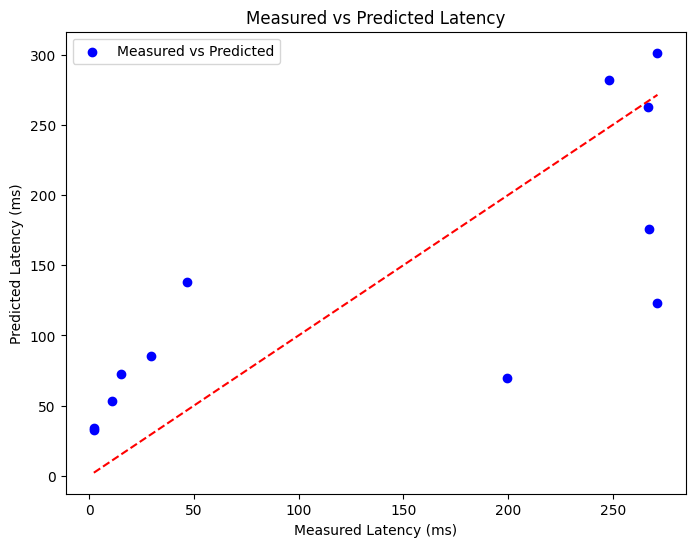

In [10]:
# NC movement only:
w1, w2, b, mae, model = fit_and_evaluate_model(X_data, y_data)

In [11]:
print(X_data)
print(y_data)

[[   12800    12800]
 [42679424    12800]
 [85346048    12800]
 [ 1920000  1920000]
 [44586624  1920000]
 [87253248  1920000]
 [   78400    78400]
 [15758400    78400]
 [31438400    78400]
 [11760000 11760000]
 [27440000 11760000]
 [43120000 11760000]]
[  2.19178799  29.29049998  46.79151298 199.39035003 271.31224802
 267.424758     2.357708    10.80856705  14.93138197 266.94228902
 248.19279002 271.31199301]


If polynomial degree 2:
`Coefficients: [-1.38776775e-04  1.39750922e-04 -1.00092592e-11  2.00601740e-11
 -1.00540817e-11], Intercept: -12.16466420296274]`

Model Type: polynomial, Degree: 2
Coefficients: [-1.38776775e-04  1.39750922e-04 -1.00092592e-11  2.00601740e-11
 -1.00540817e-11], Intercept: -12.16466420296274
Mean Absolute Error (MAE): 6.1179003825107685 ms


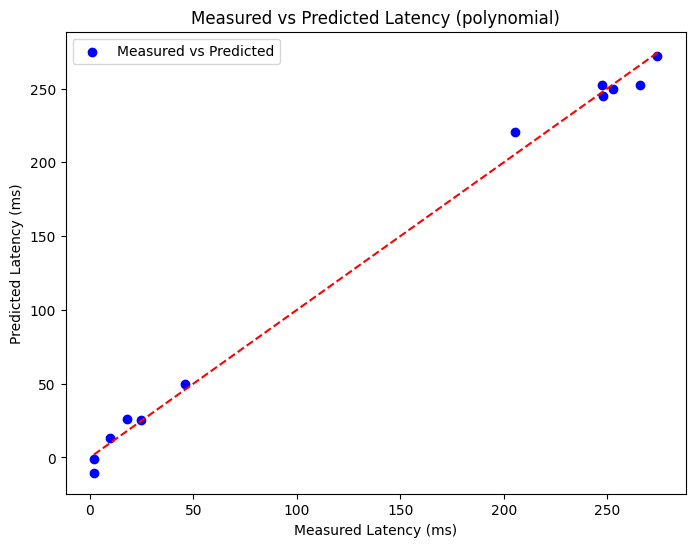

In [15]:
coefficients, intercept, mae, poly_model = fit_and_evaluate_second_order_model(X_data, y_data, model_type="polynomial", degree=2)

In [148]:
# Try out different models:
# # Linear Model
# fit_and_evaluate_model(X_data, y_data, model_type="linear")

# # Quadratic Model
# polynomial_model, _ = fit_and_evaluate_model(X_data, y_data, model_type="polynomial", degree=2)

# # Log-Transformed Model
# fit_and_evaluate_model(X_data, y_data, model_type="log")

# # Interaction Model (ND, NcD, ND*NcD)
# fit_and_evaluate_model(X_data, y_data, model_type="interaction")


In [202]:
def evaluate_existing_model(model, X_new, y_new, poly_transformer=None):
    """
    Evaluates an already trained model on new datasets.

    Args:
    - model: The pre-trained regression model.
    - X_new (numpy array): Input features for the new dataset (shape: num_samples x num_features).
    - y_new (numpy array): Actual target latencies (shape: num_samples,).
    - poly_transformer (PolynomialFeatures or None): If polynomial features were used, apply the same transformation.

    Returns:
    - mae (float): Mean Absolute Error (MAE) on the new dataset.
    """
    
    y_pred = model.predict(X_new)

    mae = mean_absolute_error(y_new, y_pred)
    print(f"Mean Absolute Error (MAE) on new dataset: {mae} ms")

    # Step 4: Visualize results
    plt.figure(figsize=(8, 6))
    plt.scatter(y_new, y_pred, label="Measured vs Predicted", color='blue')
    plt.plot([min(y_new), max(y_new)], [min(y_new), max(y_new)], color='red', linestyle='--')
    plt.xlabel("Measured Latency (ms)")
    plt.ylabel("Predicted Latency (ms)")
    plt.title("Measured vs Predicted Latency (New Dataset)")
    plt.legend()
    plt.show()

    return mae


Now evaluate on other datasets:

In [ ]:
# train 
# dbname = "SIFT10M"
xb, xq, gt, metric = load_dataset("SIFT1M")
xb, xq, gt, metric = load_dataset(dbname)

input_features_new = []
target_variable_y_new = []

for Nc in [100, 15000]:
    real_crack_index = CrackIVF(
        nlist=Nc, 
        niter=0,
        max_pts=256,
        seed=1,
        metric=metric
    )
    
    num_steps = 3
    step = max(1, xb.shape[0] // num_steps)
    for subset in range(Nc, xb.shape[0], step):
        real_crack_index.add(xb[:subset, :])

        start_t = time.perf_counter()
        _ = init_centroids_after_assignments(real_crack_index.index, debug=False, metric=metric)
        end_t = time.perf_counter()

        N, D = subset, real_crack_index.index.d
        X1 = N * D
        X2 = Nc * D

        input_features_new.append([X1, X2])
        target_variable_y_new.append((end_t - start_t) * 1000)

X_new = np.array(input_features_new)
y_new = np.array(target_variable_y_new)
mae_new = evaluate_existing_model(model, X_new, y_new, None) # linear model, it's fine that it's off I just need some guesstimate in the ball park

## REORG: Putting it together (nthreads=16):
- `T_reorg =` T_get_local_region + T_commit_reorg + T_init_centroids_after_assignments <-----
- T_get_local_region : 
    - `X1 = N_crack_locs * Nc, X2 = N_vis * D`
    - `w1 = 9.792029439425269e-07, w2 = 8.848264329863606e-07, b = 3.587780694965886`
- T_commit_reorg :
    - `X1 = Nc, X2 = N_vis * D`
    - `w1 = 4.257400629274415e-05, w2 = 3.3919302537771467e-07, b = 0.7444031045620599`
- T_init_centroids_after_assignments:
    - `X1 = N * D, X2 = N * D + Nc * D`
    - `w1 = -1.5951860751448968e-05, w2 = 1.7196139945158915e-05, b = 33.150811931567546`

In [3]:
def __cost_estimate_get_local_region(N_crack_locs, Nc, N_vis, D):
    X1, X2 = N_crack_locs * Nc, N_vis * D
    w1, w2, b = 9.792029439425269e-07, 8.848264329863606e-07, 3.587780694965886
    return w1*X1 + w2*X2 + b

def __cost_estimate_commit_reorg(Nc, N_vis, D):
    X1, X2 = Nc, N_vis * D
    w1, w2, b = 4.257400629274415e-05, 3.3919302537771467e-07, 0.7444031045620599
    return w1*X1 + w2*X2 + b

def __cost_estimate_init_centroids_after_assignment(N, D, Nc):
    X1, X2 = N*D, D*(N+Nc)
    w1, w2, b = -1.5951860751448968e-05, 1.7196139945158915e-05, 33.150811931567546
    return w1*X1 + w2*X2 + b

def get_cost_estimate_reorg(N_crack_locs, Nc, N_vis, D, N):
    '''
    Simple model to estimate cost of reorg. Uses simple linear models for fast inference. 
    Coefficiens w1,w2,b of each are learned by fitting a simple multivariat linear regression model.
    - NOTE: Has to be adjusted depending on number of threads
    '''
    # assert nthreads == 16 # because we hardcoded for 16 threads
    T_get_local_region = __cost_estimate_get_local_region(N_crack_locs, Nc, N_vis, D)
    T_commit_reorg = __cost_estimate_commit_reorg(Nc, N_vis, D)
    T_init_centroids_after_assignment = __cost_estimate_init_centroids_after_assignment(N, D, Nc)
    return T_get_local_region + T_commit_reorg + T_init_centroids_after_assignment


In [ ]:
ANN_DATASETS = [
    "deep-image-96-angular",
    "glove-25-angular",
    "glove-50-angular",
    "glove-100-angular",
    "sift-128-euclidean",
    "lastfm-64-dot",
]
# dbname = "glove-50-angular"
# dbname = "sift-128-euclidean"
dbname = "SIFT10M"
# dbname = "lastfm-64-dot"
xb, xq, gt, metric = load_dataset(dbname)
NUM_THREADS = 16
faiss.omp_set_num_threads(NUM_THREADS)

Loading Dataset = SIFT10M


Copy-paste of the reorg to measure and see if fit is fine:

In [25]:
np.random.seed(42)

In [26]:
import numpy as np
import time
from tqdm import tqdm

# Assuming the necessary imports and definitions for CrackIVF, metric, xb, xq, etc.

def get_N_visited(index, c_visited_ids):
    N_visited = 0
    D = index.d
    # in case it's multiple
    for cid in c_visited_ids:
        N_visited += index.invlists.list_size(int(cid))
    return N_visited, D

predicted_y_ms = []  # To store X1 and X2 for each measurement
target_variable_y_ms = []  # To store measured latency (T)

np.random.seed(42)

# Iterate over different values of Nc (number of centroids)
# NOTE: Vary Nc
for Nc in [100, 1000, 5000, 10000, 15000]:
    # Create new index as you vary Nc
    real_crack_index = CrackIVF(
        nlist=Nc, 
        niter=0,
        max_pts=256,  # faiss default
        seed=1,
        metric=metric
    )
    real_crack_index.verbose=False
    real_crack_index.add(xb)  # Add 1M points to the index
    real_crack_index.refine_nprobe = 1  # Control the number of invlists accessed by ncracks

    # For varying N_crack_locs (number of crack locations)
    num_points = 5  # Desired number of data points
    step = max(1, real_crack_index.nlist // num_points)  # Ensure step is at least 1
    # NOTE: Vary N_crack_locs
    for N_crack_locs in tqdm(range(1, real_crack_index.nlist, step)):
        num_steps = 3  # Desired number of data points
        step2 = max(1, xb.shape[0] // num_steps)  # Ensure step is at least 1
        # NOTE: Vary N
        for N in tqdm(range(Nc, xb.shape[0], step2)):
            real_crack_index.add(xb[:N, :])  # Add points to the index
            # Take the first N_crack_locs crack locations
            crack_locations = xq[:N_crack_locs, :]
            
            # NOTE: To estimate N_vis : you have to know c_visited_ids, and use the assignment histogram to see number of assigne points
            # Get the number of visited points (N_vis) and dimensions (D)
            
            

            ##---##---##---##---##---##---##---##---##---##---##---
            start_t_1 = time.perf_counter()
            
            ## NOTE: Approximate, Copy-Pase of reorg:( not exactly the same, but what is cut should be ~0ms overhead )
            c_visited_ids, c_visited, pids_visited, p_visited = real_crack_index._CrackIVF__get_local_region(crack_locations, 1)
            end_t_1 = time.perf_counter()
            
            # NOTE: this is not included in calculation since it will be done before
            # NOTE: Vary N_vis (depends on how points happened ot be distributed and affected by previous varied params)
            N_vis, D = get_N_visited(real_crack_index.index, c_visited_ids)
            prediction_ms = get_cost_estimate_reorg(N_crack_locs, Nc, N_vis, D, N)# Make a prediction 
            
            start_t_2 = time.perf_counter()
            # get some random assignments
            RANDOM_running_assignments = np.random.randint(0, real_crack_index.nlist-1, size=pids_visited.shape[0], dtype=int) # if "real"
            
            # needed 
            local_quantizer = faiss.IndexFlat(real_crack_index.index.d, real_crack_index.metric)
            local_quantizer.add(c_visited)

            # measure commit reorg
            _, _, _ = real_crack_index._CrackIVF__commit_reorg(
                local_quantizer, 
                c_visited_ids, 
                pids_visited, 
                p_visited, 
                use_running_assignments=True,
            )


            _ = init_centroids_after_assignments(real_crack_index.index, debug=False, metric=metric)
            end_t_2 = time.perf_counter()
            ##---##---##---##---##---##---##---##---##---##---##---

            # Append to input features and target latency
            predicted_y_ms.append(prediction_ms)
            target_variable_y_ms.append((end_t_1 - start_t_1)*1000 + (end_t_2 - start_t_2) * 1000)  # Latency in milliseconds

# Convert input features and target variable to np.array
y_pred = np.array(predicted_y_ms)  # Shape: (num_samples, 2)
y_true = np.array(target_variable_y_ms)  # Shape: (num_samples, )
# Now you can use X_data and y_data in the linear regression model  

Init Index... self.nlist=100 self.niter=0 self.max_pts=256 self.seed=1 self.d=128
	---> Index Train Time = 1138.0733120022342 ms | Add Time = 7369.9477359768935 ms | Assign Time (should be free if C++ implementation )= 2951.5086580067873<---


(1.1380733120022342, 7.3699477359768935)

  0%|          | 0/5 [00:00<?, ?it/s]

Init Index... self.nlist=100 self.niter=0 self.max_pts=256 self.seed=1 self.d=128


WARNING clustering 100 points to 100 centroids: please provide at least 3900 training points


	---> Index Train Time = 0.7457380415871739 ms | Add Time = 2.992812020238489 ms | Assign Time (should be free if C++ implementation )= 1.1289480025880039<---


(0.0007457380415871739, 0.002992812020238489)

Init Index... self.nlist=100 self.niter=0 self.max_pts=256 self.seed=1 self.d=128
	---> Index Train Time = 396.1632680147886 ms | Add Time = 1843.6139039695263 ms | Assign Time (should be free if C++ implementation )= 1126.7377720214427<---


(0.3961632680147886, 1.8436139039695263)

Init Index... self.nlist=100 self.niter=0 self.max_pts=256 self.seed=1 self.d=128
	---> Index Train Time = 746.5737810125574 ms | Add Time = 4341.565447044559 ms | Assign Time (should be free if C++ implementation )= 1955.9622200322337<---


(0.7465737810125574, 4.341565447044559)

 20%|██        | 1/5 [00:15<01:02, 15.71s/it]

Init Index... self.nlist=100 self.niter=0 self.max_pts=256 self.seed=1 self.d=128
	---> Index Train Time = 0.45632902765646577 ms | Add Time = 2.958082011900842 ms | Assign Time (should be free if C++ implementation )= 0.33910898491740227<---


WARNING clustering 100 points to 100 centroids: please provide at least 3900 training points


(0.00045632902765646577, 0.002958082011900842)

Init Index... self.nlist=100 self.niter=0 self.max_pts=256 self.seed=1 self.d=128
	---> Index Train Time = 408.4619639907032 ms | Add Time = 1687.3669969500042 ms | Assign Time (should be free if C++ implementation )= 1123.8527600071393<---


(0.4084619639907032, 1.6873669969500042)

Init Index... self.nlist=100 self.niter=0 self.max_pts=256 self.seed=1 self.d=128
	---> Index Train Time = 722.7041349979118 ms | Add Time = 3811.9388099876232 ms | Assign Time (should be free if C++ implementation )= 2128.5496540367603<---


(0.7227041349979118, 3.8119388099876232)

 40%|████      | 2/5 [00:30<00:46, 15.42s/it]

Init Index... self.nlist=100 self.niter=0 self.max_pts=256 self.seed=1 self.d=128
	---> Index Train Time = 0.7626789738424122 ms | Add Time = 3.2256420236080885 ms | Assign Time (should be free if C++ implementation )= 0.32295897835865617<---


WARNING clustering 100 points to 100 centroids: please provide at least 3900 training points


(0.0007626789738424122, 0.0032256420236080885)

Init Index... self.nlist=100 self.niter=0 self.max_pts=256 self.seed=1 self.d=128
	---> Index Train Time = 381.7268660059199 ms | Add Time = 1824.2636179784313 ms | Assign Time (should be free if C++ implementation )= 1230.0671309931204<---


(0.3817268660059199, 1.8242636179784313)

Init Index... self.nlist=100 self.niter=0 self.max_pts=256 self.seed=1 self.d=128
	---> Index Train Time = 691.4449880132452 ms | Add Time = 3571.618973976001 ms | Assign Time (should be free if C++ implementation )= 2205.5762649979442<---


(0.6914449880132452, 3.571618973976001)

 60%|██████    | 3/5 [00:46<00:30, 15.43s/it]

Init Index... self.nlist=100 self.niter=0 self.max_pts=256 self.seed=1 self.d=128
	---> Index Train Time = 0.9562780032865703 ms | Add Time = 2.9807730461470783 ms | Assign Time (should be free if C++ implementation )= 0.22913998691365123<---


WARNING clustering 100 points to 100 centroids: please provide at least 3900 training points


(0.0009562780032865703, 0.0029807730461470783)

Init Index... self.nlist=100 self.niter=0 self.max_pts=256 self.seed=1 self.d=128
	---> Index Train Time = 400.93305899063125 ms | Add Time = 1753.4741310519166 ms | Assign Time (should be free if C++ implementation )= 1089.6349149988964<---


(0.40093305899063125, 1.7534741310519166)

Init Index... self.nlist=100 self.niter=0 self.max_pts=256 self.seed=1 self.d=128
	---> Index Train Time = 693.2379640056752 ms | Add Time = 3643.5683479649015 ms | Assign Time (should be free if C++ implementation )= 2107.6636749785393<---


(0.6932379640056752, 3.6435683479649015)

 80%|████████  | 4/5 [01:01<00:15, 15.45s/it]

Init Index... self.nlist=100 self.niter=0 self.max_pts=256 self.seed=1 self.d=128
	---> Index Train Time = 0.5768290138803422 ms | Add Time = 2.8447129880078137 ms | Assign Time (should be free if C++ implementation )= 0.22207997972145677<---


WARNING clustering 100 points to 100 centroids: please provide at least 3900 training points


(0.0005768290138803422, 0.0028447129880078137)

Init Index... self.nlist=100 self.niter=0 self.max_pts=256 self.seed=1 self.d=128
	---> Index Train Time = 399.82997201150283 ms | Add Time = 1857.3220770340413 ms | Assign Time (should be free if C++ implementation )= 1081.3832539715804<---


(0.39982997201150283, 1.8573220770340413)

Init Index... self.nlist=100 self.niter=0 self.max_pts=256 self.seed=1 self.d=128
	---> Index Train Time = 705.9888039948419 ms | Add Time = 3524.0352299879305 ms | Assign Time (should be free if C++ implementation )= 2158.63076003734<---


(0.7059888039948419, 3.5240352299879305)

100%|██████████| 5/5 [01:18<00:00, 15.60s/it]


Init Index... self.nlist=1000 self.niter=0 self.max_pts=256 self.seed=1 self.d=128
	---> Index Train Time = 1168.2099520112388 ms | Add Time = 15672.214932972565 ms | Assign Time (should be free if C++ implementation )= 13959.112389013171<---


(1.1682099520112388, 15.672214932972565)

  0%|          | 0/5 [00:00<?, ?it/s]

Init Index... self.nlist=1000 self.niter=0 self.max_pts=256 self.seed=1 self.d=128
	---> Index Train Time = 1.0481469798833132 ms | Add Time = 18.38178699836135 ms | Assign Time (should be free if C++ implementation )= 1.4345870004035532<---


WARNING clustering 1000 points to 1000 centroids: please provide at least 39000 training points


(0.0010481469798833132, 0.01838178699836135)

Init Index... self.nlist=1000 self.niter=0 self.max_pts=256 self.seed=1 self.d=128
	---> Index Train Time = 446.2150320177898 ms | Add Time = 4697.603466978762 ms | Assign Time (should be free if C++ implementation )= 4923.164993000682<---


(0.4462150320177898, 4.697603466978762)

Init Index... self.nlist=1000 self.niter=0 self.max_pts=256 self.seed=1 self.d=128
	---> Index Train Time = 744.6789229870774 ms | Add Time = 12040.130054985639 ms | Assign Time (should be free if C++ implementation )= 8040.995210991241<---


(0.7446789229870774, 12.040130054985639)

 20%|██        | 1/5 [00:35<02:23, 35.93s/it]WARNING clustering 1000 points to 1000 centroids: please provide at least 39000 training points


Init Index... self.nlist=1000 self.niter=0 self.max_pts=256 self.seed=1 self.d=128
	---> Index Train Time = 0.9549669921398163 ms | Add Time = 16.97440503630787 ms | Assign Time (should be free if C++ implementation )= 2.410023007541895<---


(0.0009549669921398163, 0.01697440503630787)

Init Index... self.nlist=1000 self.niter=0 self.max_pts=256 self.seed=1 self.d=128
	---> Index Train Time = 469.69128301134333 ms | Add Time = 4649.831079004798 ms | Assign Time (should be free if C++ implementation )= 4080.602767004166<---


(0.46969128301134333, 4.649831079004798)

Init Index... self.nlist=1000 self.niter=0 self.max_pts=256 self.seed=1 self.d=128
	---> Index Train Time = 713.4303399943747 ms | Add Time = 8973.333098983858 ms | Assign Time (should be free if C++ implementation )= 8839.355496980716<---


(0.7134303399943747, 8.973333098983858)

 40%|████      | 2/5 [01:09<01:43, 34.34s/it]WARNING clustering 1000 points to 1000 centroids: please provide at least 39000 training points


Init Index... self.nlist=1000 self.niter=0 self.max_pts=256 self.seed=1 self.d=128
	---> Index Train Time = 0.8485480211675167 ms | Add Time = 16.42886095214635 ms | Assign Time (should be free if C++ implementation )= 5.501036997884512<---


(0.0008485480211675167, 0.01642886095214635)

Init Index... self.nlist=1000 self.niter=0 self.max_pts=256 self.seed=1 self.d=128
	---> Index Train Time = 428.68431902024895 ms | Add Time = 4343.235576001462 ms | Assign Time (should be free if C++ implementation )= 4361.830922018271<---


(0.42868431902024895, 4.343235576001462)

Init Index... self.nlist=1000 self.niter=0 self.max_pts=256 self.seed=1 self.d=128
	---> Index Train Time = 702.6276369579136 ms | Add Time = 9737.962006998714 ms | Assign Time (should be free if C++ implementation )= 7543.244374974165<---


(0.7026276369579136, 9.737962006998714)

 60%|██████    | 3/5 [01:41<01:06, 33.24s/it]WARNING clustering 1000 points to 1000 centroids: please provide at least 39000 training points


Init Index... self.nlist=1000 self.niter=0 self.max_pts=256 self.seed=1 self.d=128
	---> Index Train Time = 0.4590179887600243 ms | Add Time = 15.69596299668774 ms | Assign Time (should be free if C++ implementation )= 2.719604002777487<---


(0.0004590179887600243, 0.01569596299668774)

Init Index... self.nlist=1000 self.niter=0 self.max_pts=256 self.seed=1 self.d=128
	---> Index Train Time = 386.27272995654494 ms | Add Time = 4204.240497027058 ms | Assign Time (should be free if C++ implementation )= 3901.670983992517<---


(0.38627272995654494, 4.204240497027058)

Init Index... self.nlist=1000 self.niter=0 self.max_pts=256 self.seed=1 self.d=128
	---> Index Train Time = 701.2272460269742 ms | Add Time = 9470.712184964214 ms | Assign Time (should be free if C++ implementation )= 8469.380748982076<---


(0.7012272460269742, 9.470712184964214)

 80%|████████  | 4/5 [02:13<00:32, 32.93s/it]

Init Index... self.nlist=1000 self.niter=0 self.max_pts=256 self.seed=1 self.d=128
	---> Index Train Time = 0.5176489939913154 ms | Add Time = 15.010803006589413 ms | Assign Time (should be free if C++ implementation )= 1.780536025762558<---


WARNING clustering 1000 points to 1000 centroids: please provide at least 39000 training points


(0.0005176489939913154, 0.015010803006589413)

Init Index... self.nlist=1000 self.niter=0 self.max_pts=256 self.seed=1 self.d=128
	---> Index Train Time = 355.64425599295646 ms | Add Time = 4152.071100019384 ms | Assign Time (should be free if C++ implementation )= 4429.63657603832<---


(0.35564425599295646, 4.152071100019384)

Init Index... self.nlist=1000 self.niter=0 self.max_pts=256 self.seed=1 self.d=128
	---> Index Train Time = 697.4465450039133 ms | Add Time = 8446.74683402991 ms | Assign Time (should be free if C++ implementation )= 7696.009997045621<---


(0.6974465450039133, 8.44674683402991)

100%|██████████| 5/5 [02:44<00:00, 32.96s/it]


Init Index... self.nlist=5000 self.niter=0 self.max_pts=256 self.seed=1 self.d=128
	---> Index Train Time = 1128.4194379695691 ms | Add Time = 62554.74128003698 ms | Assign Time (should be free if C++ implementation )= 52003.28526698286<---


(1.1284194379695691, 62.55474128003698)

  0%|          | 0/5 [00:00<?, ?it/s]

Init Index... self.nlist=5000 self.niter=0 self.max_pts=256 self.seed=1 self.d=128
	---> Index Train Time = 2.3182969889603555 ms | Add Time = 88.23422796558589 ms | Assign Time (should be free if C++ implementation )= 25.968700007069856<---


WARNING clustering 5000 points to 5000 centroids: please provide at least 195000 training points


(0.0023182969889603555, 0.08823422796558589)

Init Index... self.nlist=5000 self.niter=0 self.max_pts=256 self.seed=1 self.d=128
	---> Index Train Time = 530.8110989863053 ms | Add Time = 22231.028278998565 ms | Assign Time (should be free if C++ implementation )= 18548.96543599898<---


(0.5308110989863053, 22.231028278998565)

Init Index... self.nlist=5000 self.niter=0 self.max_pts=256 self.seed=1 self.d=128
	---> Index Train Time = 1854.7846790170297 ms | Add Time = 38500.931078975555 ms | Assign Time (should be free if C++ implementation )= 35350.84098594962<---


(1.8547846790170297, 38.500931078975555)

 20%|██        | 1/5 [02:02<08:11, 122.98s/it]

Init Index... self.nlist=5000 self.niter=0 self.max_pts=256 self.seed=1 self.d=128
	---> Index Train Time = 2.1009459742344916 ms | Add Time = 91.81466395966709 ms | Assign Time (should be free if C++ implementation )= 28.17137201782316<---


WARNING clustering 5000 points to 5000 centroids: please provide at least 195000 training points


(0.0021009459742344916, 0.09181466395966709)

Init Index... self.nlist=5000 self.niter=0 self.max_pts=256 self.seed=1 self.d=128
	---> Index Train Time = 1280.5635040276684 ms | Add Time = 18481.963545025792 ms | Assign Time (should be free if C++ implementation )= 22318.00582597498<---


(1.2805635040276684, 18.481963545025792)

Init Index... self.nlist=5000 self.niter=0 self.max_pts=256 self.seed=1 self.d=128
	---> Index Train Time = 1685.6821019900963 ms | Add Time = 37472.28733304655 ms | Assign Time (should be free if C++ implementation )= 35513.92298704013<---


(1.6856821019900963, 37.47228733304655)

 40%|████      | 2/5 [04:02<06:03, 121.23s/it]

Init Index... self.nlist=5000 self.niter=0 self.max_pts=256 self.seed=1 self.d=128
	---> Index Train Time = 1.924478041473776 ms | Add Time = 87.42575999349356 ms | Assign Time (should be free if C++ implementation )= 25.723908038344234<---


WARNING clustering 5000 points to 5000 centroids: please provide at least 195000 training points


(0.001924478041473776, 0.08742575999349356)

Init Index... self.nlist=5000 self.niter=0 self.max_pts=256 self.seed=1 self.d=128
	---> Index Train Time = 516.4691040408798 ms | Add Time = 20329.216108017135 ms | Assign Time (should be free if C++ implementation )= 17750.930598005652<---


(0.5164691040408798, 20.329216108017135)

Init Index... self.nlist=5000 self.niter=0 self.max_pts=256 self.seed=1 self.d=128
	---> Index Train Time = 1274.3867139797658 ms | Add Time = 40363.626857986674 ms | Assign Time (should be free if C++ implementation )= 35341.14380599931<---


(1.2743867139797658, 40.363626857986674)

 60%|██████    | 3/5 [06:02<04:00, 120.25s/it]

Init Index... self.nlist=5000 self.niter=0 self.max_pts=256 self.seed=1 self.d=128
	---> Index Train Time = 1.877497008536011 ms | Add Time = 99.39729399047792 ms | Assign Time (should be free if C++ implementation )= 29.997968988027424<---


WARNING clustering 5000 points to 5000 centroids: please provide at least 195000 training points


(0.001877497008536011, 0.09939729399047792)

Init Index... self.nlist=5000 self.niter=0 self.max_pts=256 self.seed=1 self.d=128
	---> Index Train Time = 431.780737999361 ms | Add Time = 20760.56627597427 ms | Assign Time (should be free if C++ implementation )= 19721.4913519565<---


(0.431780737999361, 20.76056627597427)

Init Index... self.nlist=5000 self.niter=0 self.max_pts=256 self.seed=1 self.d=128
	---> Index Train Time = 1189.5754570141435 ms | Add Time = 41408.98033796111 ms | Assign Time (should be free if C++ implementation )= 34833.77315697726<---


(1.1895754570141435, 41.40898033796111)

 80%|████████  | 4/5 [08:03<02:00, 120.71s/it]WARNING clustering 5000 points to 5000 centroids: please provide at least 195000 training points


Init Index... self.nlist=5000 self.niter=0 self.max_pts=256 self.seed=1 self.d=128
	---> Index Train Time = 1.08206900767982 ms | Add Time = 91.65244997711852 ms | Assign Time (should be free if C++ implementation )= 26.343901990912855<---


(0.00108206900767982, 0.09165244997711852)

Init Index... self.nlist=5000 self.niter=0 self.max_pts=256 self.seed=1 self.d=128
	---> Index Train Time = 387.580220005475 ms | Add Time = 20787.58837899659 ms | Assign Time (should be free if C++ implementation )= 19995.54973602062<---


(0.387580220005475, 20.78758837899659)

Init Index... self.nlist=5000 self.niter=0 self.max_pts=256 self.seed=1 self.d=128
	---> Index Train Time = 767.1103599714115 ms | Add Time = 48093.96263194503 ms | Assign Time (should be free if C++ implementation )= 36075.97285200609<---


(0.7671103599714115, 48.09396263194503)

100%|██████████| 5/5 [10:14<00:00, 122.90s/it]


Init Index... self.nlist=10000 self.niter=0 self.max_pts=256 self.seed=1 self.d=128
	---> Index Train Time = 1230.0557410344481 ms | Add Time = 110787.50284702983 ms | Assign Time (should be free if C++ implementation )= 106712.29470596882<---


(1.2300557410344481, 110.78750284702983)

  0%|          | 0/5 [00:00<?, ?it/s]

Init Index... self.nlist=10000 self.niter=0 self.max_pts=256 self.seed=1 self.d=128


WARNING clustering 10000 points to 10000 centroids: please provide at least 390000 training points


	---> Index Train Time = 3.2721470342949033 ms | Add Time = 238.9886899618432 ms | Assign Time (should be free if C++ implementation )= 115.42197002563626<---


(0.0032721470342949033, 0.2389886899618432)

Init Index... self.nlist=10000 self.niter=0 self.max_pts=256 self.seed=1 self.d=128
	---> Index Train Time = 512.3536320170388 ms | Add Time = 37405.2217269782 ms | Assign Time (should be free if C++ implementation )= 35931.39575701207<---


(0.5123536320170388, 37.4052217269782)

Init Index... self.nlist=10000 self.niter=0 self.max_pts=256 self.seed=1 self.d=128
	---> Index Train Time = 1684.4385029980913 ms | Add Time = 82557.15248303022 ms | Assign Time (should be free if C++ implementation )= 72184.72333496902<---


(1.6844385029980913, 82.55715248303022)

 20%|██        | 1/5 [03:54<15:36, 234.13s/it]

Init Index... self.nlist=10000 self.niter=0 self.max_pts=256 self.seed=1 self.d=128


WARNING clustering 10000 points to 10000 centroids: please provide at least 390000 training points


	---> Index Train Time = 2.4874169612303376 ms | Add Time = 251.0184819693677 ms | Assign Time (should be free if C++ implementation )= 129.3428320204839<---


(0.0024874169612303376, 0.2510184819693677)

Init Index... self.nlist=10000 self.niter=0 self.max_pts=256 self.seed=1 self.d=128
	---> Index Train Time = 542.2720150090754 ms | Add Time = 41512.33112596674 ms | Assign Time (should be free if C++ implementation )= 36244.58900798345<---


(0.5422720150090754, 41.51233112596674)

Init Index... self.nlist=10000 self.niter=0 self.max_pts=256 self.seed=1 self.d=128
	---> Index Train Time = 2005.5355920339935 ms | Add Time = 81774.44217301672 ms | Assign Time (should be free if C++ implementation )= 79986.63097800454<---


(2.0055355920339935, 81.77444217301672)

 40%|████      | 2/5 [08:00<12:03, 241.33s/it]

Init Index... self.nlist=10000 self.niter=0 self.max_pts=256 self.seed=1 self.d=128


WARNING clustering 10000 points to 10000 centroids: please provide at least 390000 training points


	---> Index Train Time = 2.8123469674028456 ms | Add Time = 255.2259939839132 ms | Assign Time (should be free if C++ implementation )= 126.73354800790548<---


(0.0028123469674028456, 0.2552259939839132)

Init Index... self.nlist=10000 self.niter=0 self.max_pts=256 self.seed=1 self.d=128
	---> Index Train Time = 535.9616169589572 ms | Add Time = 36917.459227959625 ms | Assign Time (should be free if C++ implementation )= 35127.085388987325<---


(0.5359616169589572, 36.917459227959625)

Init Index... self.nlist=10000 self.niter=0 self.max_pts=256 self.seed=1 self.d=128
	---> Index Train Time = 1500.0723399571143 ms | Add Time = 82610.56090297643 ms | Assign Time (should be free if C++ implementation )= 72887.65958003933<---


(1.5000723399571143, 82.61056090297643)

 60%|██████    | 3/5 [11:54<07:55, 237.79s/it]

Init Index... self.nlist=10000 self.niter=0 self.max_pts=256 self.seed=1 self.d=128


WARNING clustering 10000 points to 10000 centroids: please provide at least 390000 training points


	---> Index Train Time = 3.450435004197061 ms | Add Time = 242.55262000951916 ms | Assign Time (should be free if C++ implementation )= 117.27168399374932<---


(0.003450435004197061, 0.24255262000951916)

Init Index... self.nlist=10000 self.niter=0 self.max_pts=256 self.seed=1 self.d=128
	---> Index Train Time = 831.9940089713782 ms | Add Time = 40227.43054898456 ms | Assign Time (should be free if C++ implementation )= 38750.923999992665<---


(0.8319940089713782, 40.22743054898456)

Init Index... self.nlist=10000 self.niter=0 self.max_pts=256 self.seed=1 self.d=128
	---> Index Train Time = 1487.7891350188293 ms | Add Time = 74044.41880702507 ms | Assign Time (should be free if C++ implementation )= 77657.11786900647<---


(1.4877891350188293, 74.04441880702507)

 80%|████████  | 4/5 [15:53<03:58, 238.33s/it]

Init Index... self.nlist=10000 self.niter=0 self.max_pts=256 self.seed=1 self.d=128


WARNING clustering 10000 points to 10000 centroids: please provide at least 390000 training points


	---> Index Train Time = 2.8316070092841983 ms | Add Time = 233.2029899698682 ms | Assign Time (should be free if C++ implementation )= 124.40593499923125<---


(0.0028316070092841983, 0.2332029899698682)

Init Index... self.nlist=10000 self.niter=0 self.max_pts=256 self.seed=1 self.d=128
	---> Index Train Time = 1755.2750770119019 ms | Add Time = 39155.14930599602 ms | Assign Time (should be free if C++ implementation )= 39192.43598898174<---


(1.7552750770119019, 39.15514930599602)

Init Index... self.nlist=10000 self.niter=0 self.max_pts=256 self.seed=1 self.d=128
	---> Index Train Time = 1929.9797300482169 ms | Add Time = 81285.90407496085 ms | Assign Time (should be free if C++ implementation )= 79273.89789902372<---


(1.9299797300482169, 81.28590407496085)

100%|██████████| 5/5 [20:01<00:00, 240.26s/it]


Init Index... self.nlist=15000 self.niter=0 self.max_pts=256 self.seed=1 self.d=128
	---> Index Train Time = 1732.3932749568485 ms | Add Time = 167074.41780297086 ms | Assign Time (should be free if C++ implementation )= 173388.98665702436<---


(1.7323932749568485, 167.07441780297086)

  0%|          | 0/5 [00:00<?, ?it/s]

Init Index... self.nlist=15000 self.niter=0 self.max_pts=256 self.seed=1 self.d=128


WARNING clustering 15000 points to 15000 centroids: please provide at least 585000 training points


	---> Index Train Time = 9.27425897680223 ms | Add Time = 471.0588739835657 ms | Assign Time (should be free if C++ implementation )= 266.0745909670368<---


(0.00927425897680223, 0.4710588739835657)

Init Index... self.nlist=15000 self.niter=0 self.max_pts=256 self.seed=1 self.d=128
	---> Index Train Time = 291.6829999885522 ms | Add Time = 54536.413783964235 ms | Assign Time (should be free if C++ implementation )= 53078.31361400895<---


(0.2916829999885522, 54.536413783964235)

Init Index... self.nlist=15000 self.niter=0 self.max_pts=256 self.seed=1 self.d=128
	---> Index Train Time = 2931.406142015476 ms | Add Time = 109930.52638799418 ms | Assign Time (should be free if C++ implementation )= 104111.22973903548<---


(2.931406142015476, 109.93052638799418)

 20%|██        | 1/5 [05:30<22:03, 330.90s/it]

Init Index... self.nlist=15000 self.niter=0 self.max_pts=256 self.seed=1 self.d=128


WARNING clustering 15000 points to 15000 centroids: please provide at least 585000 training points


	---> Index Train Time = 3.3421359839849174 ms | Add Time = 453.9125359733589 ms | Assign Time (should be free if C++ implementation )= 251.97559298248962<---


(0.0033421359839849174, 0.4539125359733589)

Init Index... self.nlist=15000 self.niter=0 self.max_pts=256 self.seed=1 self.d=128
	---> Index Train Time = 277.19287300715223 ms | Add Time = 51661.19857894955 ms | Assign Time (should be free if C++ implementation )= 51190.668591996655<---


(0.27719287300715223, 51.66119857894955)

Init Index... self.nlist=15000 self.niter=0 self.max_pts=256 self.seed=1 self.d=128
	---> Index Train Time = 2741.4844590239227 ms | Add Time = 118000.91289897682 ms | Assign Time (should be free if C++ implementation )= 110093.55308295926<---


(2.7414844590239227, 118.00091289897682)

 40%|████      | 2/5 [11:10<16:47, 335.80s/it]

Init Index... self.nlist=15000 self.niter=0 self.max_pts=256 self.seed=1 self.d=128


WARNING clustering 15000 points to 15000 centroids: please provide at least 585000 training points


	---> Index Train Time = 4.096683987881988 ms | Add Time = 503.7178189959377 ms | Assign Time (should be free if C++ implementation )= 260.63675701152533<---


(0.004096683987881988, 0.5037178189959377)

Init Index... self.nlist=15000 self.niter=0 self.max_pts=256 self.seed=1 self.d=128
	---> Index Train Time = 294.15939399041235 ms | Add Time = 57195.85945998551 ms | Assign Time (should be free if C++ implementation )= 58180.64720201073<---


(0.29415939399041235, 57.19585945998551)

Init Index... self.nlist=15000 self.niter=0 self.max_pts=256 self.seed=1 self.d=128
	---> Index Train Time = 2714.666420011781 ms | Add Time = 120294.86570204608 ms | Assign Time (should be free if C++ implementation )= 120490.69260200486<---


(2.714666420011781, 120.29486570204608)

 60%|██████    | 3/5 [17:17<11:40, 350.33s/it]

Init Index... self.nlist=15000 self.niter=0 self.max_pts=256 self.seed=1 self.d=128


WARNING clustering 15000 points to 15000 centroids: please provide at least 585000 training points


	---> Index Train Time = 3.1776450341567397 ms | Add Time = 447.80089595587924 ms | Assign Time (should be free if C++ implementation )= 272.5758720189333<---


(0.0031776450341567397, 0.44780089595587924)

Init Index... self.nlist=15000 self.niter=0 self.max_pts=256 self.seed=1 self.d=128
	---> Index Train Time = 475.4329530405812 ms | Add Time = 59772.876795963384 ms | Assign Time (should be free if C++ implementation )= 51838.86080799857<---


(0.4754329530405812, 59.772876795963384)

Init Index... self.nlist=15000 self.niter=0 self.max_pts=256 self.seed=1 self.d=128
	---> Index Train Time = 3019.3176770117134 ms | Add Time = 105025.13960801298 ms | Assign Time (should be free if C++ implementation )= 105579.36341903405<---


(3.0193176770117134, 105.02513960801298)

 80%|████████  | 4/5 [22:49<05:42, 342.87s/it]

Init Index... self.nlist=15000 self.niter=0 self.max_pts=256 self.seed=1 self.d=128


WARNING clustering 15000 points to 15000 centroids: please provide at least 585000 training points


	---> Index Train Time = 3.5405560047365725 ms | Add Time = 420.71301996475086 ms | Assign Time (should be free if C++ implementation )= 248.11696400865912<---


(0.0035405560047365725, 0.42071301996475086)

Init Index... self.nlist=15000 self.niter=0 self.max_pts=256 self.seed=1 self.d=128
	---> Index Train Time = 352.5942499982193 ms | Add Time = 51549.40748400986 ms | Assign Time (should be free if C++ implementation )= 50224.375067977235<---


(0.3525942499982193, 51.54940748400986)

Init Index... self.nlist=15000 self.niter=0 self.max_pts=256 self.seed=1 self.d=128
	---> Index Train Time = 1950.4038920276798 ms | Add Time = 103119.76526398212 ms | Assign Time (should be free if C++ implementation )= 99540.04226496909<---


(1.9504038920276798, 103.11976526398212)

100%|██████████| 5/5 [28:01<00:00, 336.31s/it]


In [27]:
import numpy as np
from sklearn.metrics import mean_squared_error

# Assuming y_true and y_pred are defined and y_true contains the true latencies (in ms)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
print(f"{dbname=}")
print("MSE (in ms^2):", mse)
print("RMSE (in ms):", rmse)
r2 = r2_score(y_true, y_pred)
print("R2 Score:", r2)


dbname='SIFT10M'
MSE (in ms^2): 70662.47466026989
RMSE (in ms): 265.82414235781874
R2 Score: 0.7524214600869532


In [28]:
mse = mean_squared_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)
print("MSE:", mse)
print("R2 Score:", r2)

MSE: 70662.47466026989
R2 Score: 0.7524214600869532


<Figure size 800x600 with 0 Axes>

Text(0.5, 0, 'Measured Latency (ms)')

Text(0, 0.5, 'Predicted Latency (ms)')

Text(0.5, 1.0, 'Measured vs Predicted Latency - SIFT10M')

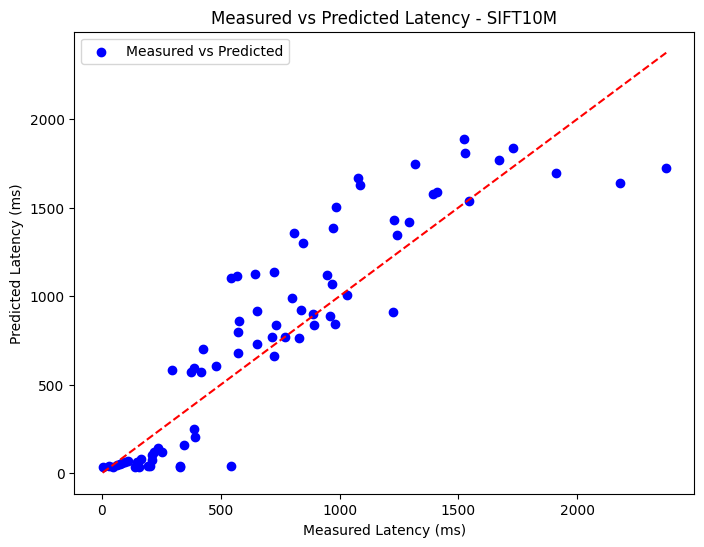

In [31]:
import matplotlib.pyplot as plt

# Visualize the results (Measured vs. Predicted Latency)
plt.figure(figsize=(8, 6))
plt.scatter(y_true, y_pred, label="Measured vs Predicted", color='blue')
plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], color='red', linestyle='--')
plt.xlabel("Measured Latency (ms)")
plt.ylabel("Predicted Latency (ms)")
plt.title(f"Measured vs Predicted Latency - {dbname}")
plt.legend()
plt.show()


<Figure size 800x600 with 0 Axes>

Text(0.5, 0, 'Measured Latency (ms)')

Text(0, 0.5, 'Predicted Latency (ms)')

Text(0.5, 1.0, 'Measured vs Predicted Latency - lastfm-64-dot')

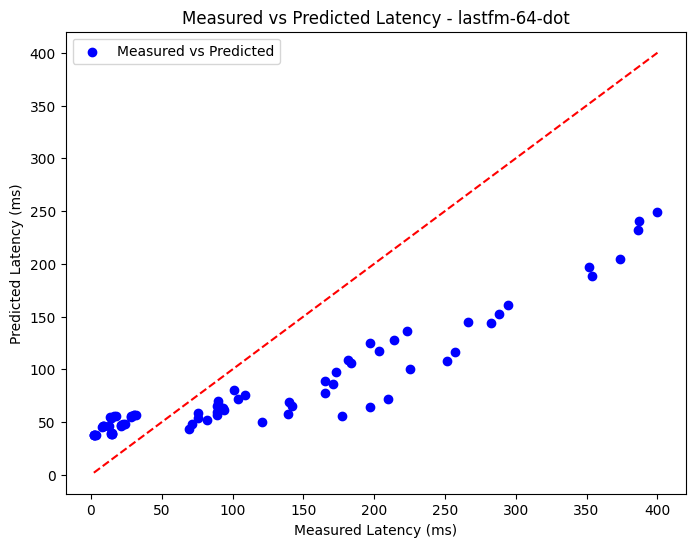

In [22]:
import matplotlib.pyplot as plt

# Visualize the results (Measured vs. Predicted Latency)
plt.figure(figsize=(8, 6))
plt.scatter(y_true, y_pred, label="Measured vs Predicted", color='blue')
plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], color='red', linestyle='--')
plt.xlabel("Measured Latency (ms)")
plt.ylabel("Predicted Latency (ms)")
plt.title(f"Measured vs Predicted Latency - {dbname}")
plt.legend()
plt.show()


<Figure size 800x600 with 0 Axes>

Text(0.5, 0, 'Measured Latency (ms)')

Text(0, 0.5, 'Predicted Latency (ms)')

Text(0.5, 1.0, 'Measured vs Predicted Latency - mnist-784-euclidean')

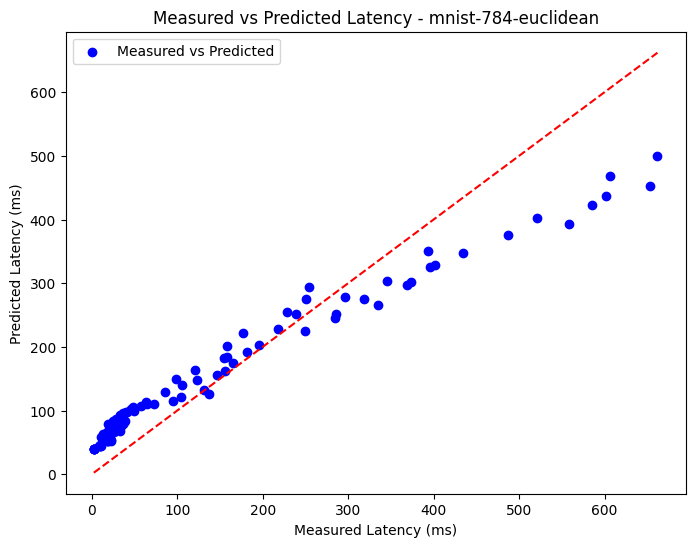

In [17]:
import matplotlib.pyplot as plt

# Visualize the results (Measured vs. Predicted Latency)
plt.figure(figsize=(8, 6))
plt.scatter(y_true, y_pred, label="Measured vs Predicted", color='blue')
plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], color='red', linestyle='--')
plt.xlabel("Measured Latency (ms)")
plt.ylabel("Predicted Latency (ms)")
plt.title(f"Measured vs Predicted Latency - {dbname}")
plt.legend()
plt.show()


<Figure size 800x600 with 0 Axes>

Text(0.5, 0, 'Measured Latency (ms)')

Text(0, 0.5, 'Predicted Latency (ms)')

Text(0.5, 1.0, 'Measured vs Predicted Latency - glove-50-angular')

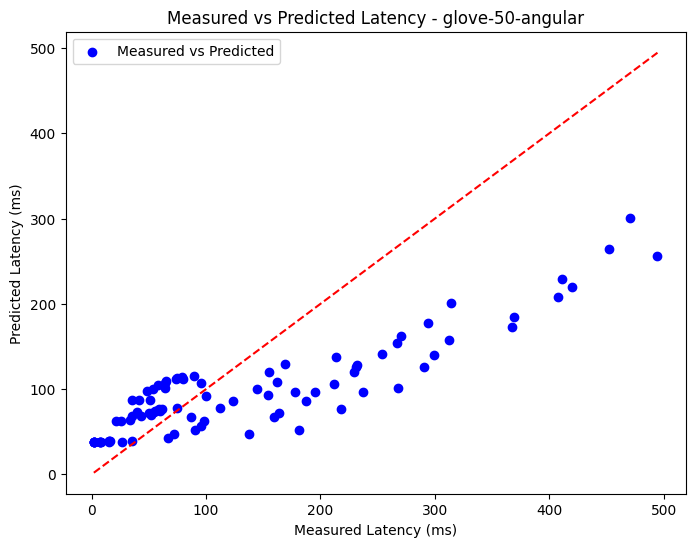

In [10]:
import matplotlib.pyplot as plt

# Visualize the results (Measured vs. Predicted Latency)
plt.figure(figsize=(8, 6))
plt.scatter(y_true, y_pred, label="Measured vs Predicted", color='blue')
plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], color='red', linestyle='--')
plt.xlabel("Measured Latency (ms)")
plt.ylabel("Predicted Latency (ms)")
plt.title(f"Measured vs Predicted Latency - {dbname}")
plt.legend()
plt.show()


<Figure size 800x600 with 0 Axes>

Text(0.5, 0, 'Measured Latency (ms)')

Text(0, 0.5, 'Predicted Latency (ms)')

Text(0.5, 1.0, 'Measured vs Predicted Latency - sift-128-euclidean')

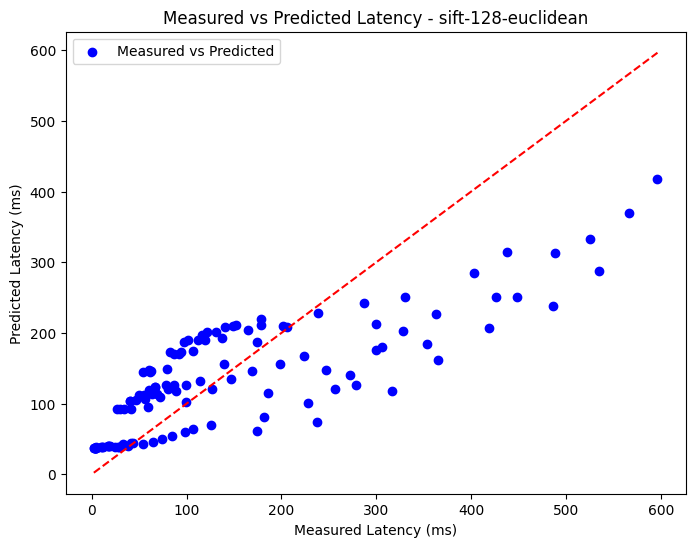

In [37]:
import matplotlib.pyplot as plt

# Visualize the results (Measured vs. Predicted Latency)
plt.figure(figsize=(8, 6))
plt.scatter(y_true, y_pred, label="Measured vs Predicted", color='blue')
plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], color='red', linestyle='--')
plt.xlabel("Measured Latency (ms)")
plt.ylabel("Predicted Latency (ms)")
plt.title(f"Measured vs Predicted Latency - {dbname}")
plt.legend()
plt.show()


# Refine

## Local Kmeans cost
`def __refine_cracks_locally(self, c_visited_ids, c_visited, p_visited):`
- `Final : T = w1 * ( n_iter *  N_train * C_vis * D ) + w2 *  ( Nc * D ) + b`
    - where: N_train = min(max_pts*N_vis, N_vis)
- `w1 = 9.311884586956287e-09, w2 = 7.437262586898243e-05, b = 191.62760060405162`


``` python

    def __refine_cracks_locally(self, c_visited_ids, c_visited, p_visited):

        num_partitions = len(c_visited) # num partitions to refine/reorg
            local_km = faiss.Kmeans(self.d, num_partitions, niter=1, max_points_per_centroid=self.max_pts)
        local_km.verbose = self.verbose
        # NOTE: Train is compute and data movement heavy, but same complexity so we can only take compute into account and have w1 learned parameter handle it
        local_km.train(p_visited, init_centroids=c_visited)
        
        refined_local_quantizer = local_km.index # after it has been refined...
        self.cracks[c_visited_ids] = local_km.centroids # update outer cracks
        # NOTE: updating global quantizer is Data Movement heavy, where you just add the global centorid C and update them, we let paramete w2 handle this part of the kernel
        refined_global_quantizer = faiss.IndexFlat(self.d, self.metric)
        refined_global_quantizer.add(self.cracks)
        
        _ = replace_ivf_quantizer(self.index, refined_global_quantizer)
        
        return refined_local_quantizer
```

In [23]:
# Assuming the necessary imports and definitions for CrackIVF, metric, xb, xq, etc.

def get_local_kmeans_measurements(xb,xq):
    
    def get_N_visited(index, c_visited_ids):
        N_visited = 0
        D = index.d
        # in case it's multiple
        for cid in c_visited_ids:
            N_visited += index.invlists.list_size(int(cid))
        return N_visited, D

    input_features = []  # To store X1 and X2 for each measurement
    target_variable_y_ms = []  # To store measured latency (T)

    max_pts = 256 # FAISS DEFAULT
    n_iter = 1 # we typically only do 1 iteration 

    # Iterate over different values of Nc (number of centroids)
    for Nc in [100, 200, 500, 1000, 2000, 5000, 10000, 15000]:
        
        # Create new index as you vary Nc
        real_crack_index = CrackIVF(
            nlist=Nc, 
            niter=0,
            max_pts=256,  # faiss default
            seed=1,
            metric=metric
        )
        real_crack_index.add(xb)  # Add 1M points to the index
        GLOBAL_CRACKS = real_crack_index.index.reconstruct_n() # centroids

        # For varying N_crack_locs (number of crack locations)
        num_data_points = 10  # Desired number of data points
        step = max(1, real_crack_index.nlist // num_data_points)  # Ensure step is at least 1

        for C_vis in tqdm(range(1, real_crack_index.nlist, step)):
            
            real_crack_index.refine_nprobe = C_vis  # Control the number of invlists accessed by ncracks
            
            query = xq[0:1, :] # just get one query and then we vary local region size around it in C_vis
            
            # 1) get local region for C_vis 
            c_visited_ids, c_visited, pids_visited, p_visited = real_crack_index._CrackIVF__get_local_region(query, C_vis)
            
            # Get the number of visited points (N_vis) and dimensions (D)
            # Get the number of poitns we run kmeans train N_train
            N_vis, D = get_N_visited(real_crack_index.index, c_visited_ids)
            N_train = min(max_pts*N_vis, N_vis)

            start_t = time.perf_counter()
            
            # the compute heavy op (X1)
            local_km = faiss.Kmeans(D, C_vis, niter=n_iter, max_points_per_centroid=max_pts)
            local_km.train(p_visited) 
            # the data movement heavey op (X2)
            GLOBAL_CRACKS[c_visited_ids] = local_km.centroids # update local cracks
            refined_global_quantizer = faiss.IndexFlat(D)
            refined_global_quantizer.add(GLOBAL_CRACKS) # add global cracks no need to add refine
            end_t = time.perf_counter()

            
            # Store input features and target variable
            X1 = n_iter * N_train * C_vis * D
            X2 = Nc * D 
            
            # Append to input features and target latency
            input_features.append([X1, X2])
            target_variable_y_ms.append((end_t - start_t) * 1000)  # Latency in milliseconds

            # print(f"{local_km.centroids.shape=}")
            # print(f"{c_visited_ids=}")
            # print(f"{GLOBAL_CRACKS.shape=}")


    # Convert input features and target variable to np.array
    X_data = np.array(input_features)  # Shape: (num_samples, 2)
    y_data = np.array(target_variable_y_ms)  # Shape: (num_samples, )
    return X_data, y_data
    # Now you can use X_data and y_data in the linear regression model

In [ ]:
X_data, y_data = get_local_kmeans_measurements(xb,xq)

Init Index... self.nlist=100 self.niter=0 self.max_pts=256 self.seed=1 self.d=128
	---> Index Train Time = 53.24513203231618 ms | Add Time = 478.7849700078368 ms | Assign Time (should be free if C++ implementation )= 257.9544589971192<---


100%|██████████| 10/10 [00:03<00:00,  2.66it/s]


Init Index... self.nlist=200 self.niter=0 self.max_pts=256 self.seed=1 self.d=128
	---> Index Train Time = 59.69765194458887 ms | Add Time = 522.0940920407884 ms | Assign Time (should be free if C++ implementation )= 334.6895099966787<---


100%|██████████| 10/10 [00:03<00:00,  2.65it/s]


Init Index... self.nlist=500 self.niter=0 self.max_pts=256 self.seed=1 self.d=128
	---> Index Train Time = 66.58722105203196 ms | Add Time = 864.9213460157625 ms | Assign Time (should be free if C++ implementation )= 701.9213430467062<---


100%|██████████| 10/10 [00:03<00:00,  2.50it/s]


Init Index... self.nlist=1000 self.niter=0 self.max_pts=256 self.seed=1 self.d=128
	---> Index Train Time = 80.50164999440312 ms | Add Time = 1437.8383760340512 ms | Assign Time (should be free if C++ implementation )= 1814.9766090209596<---


100%|██████████| 10/10 [00:05<00:00,  1.95it/s]


Init Index... self.nlist=2000 self.niter=0 self.max_pts=256 self.seed=1 self.d=128
	---> Index Train Time = 107.50523896422237 ms | Add Time = 2699.154217960313 ms | Assign Time (should be free if C++ implementation )= 2553.9931320236064<---


100%|██████████| 10/10 [00:08<00:00,  1.25it/s]


Init Index... self.nlist=5000 self.niter=0 self.max_pts=256 self.seed=1 self.d=128
	---> Index Train Time = 54.13682898506522 ms | Add Time = 6246.886861976236 ms | Assign Time (should be free if C++ implementation )= 6026.724579976872<---


100%|██████████| 10/10 [00:19<00:00,  1.98s/it]


Init Index... self.nlist=10000 self.niter=0 self.max_pts=256 self.seed=1 self.d=128
	---> Index Train Time = 52.212767011951655 ms | Add Time = 12383.480703982059 ms | Assign Time (should be free if C++ implementation )= 11958.674790977966<---


100%|██████████| 10/10 [00:35<00:00,  3.58s/it]


Init Index... self.nlist=15000 self.niter=0 self.max_pts=256 self.seed=1 self.d=128
	---> Index Train Time = 54.85441896598786 ms | Add Time = 16502.445323974825 ms | Assign Time (should be free if C++ implementation )= 16224.172385991551<---


100%|██████████| 10/10 [00:52<00:00,  5.28s/it]


Fitted model: T = w1 * X1 + w2 * X2 + b
w1 = 9.311884586956287e-09, w2 = 7.437262586898243e-05, b = 191.62760060405162
Mean Absolute Error (MAE): 112.45251990426168 ms


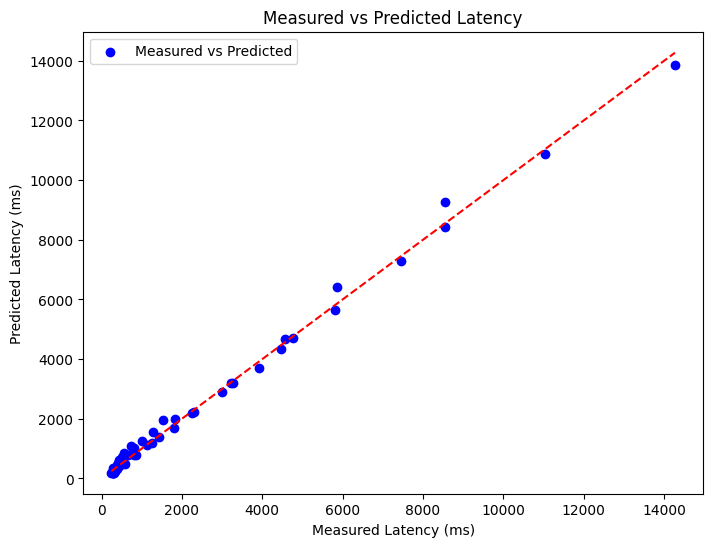

9.311884586956287e-09

7.437262586898243e-05

191.62760060405162

dbname='sift-128-euclidean'
MSE (in ms^2): 27064.24133044696
RMSE (in ms): 164.51213125616894
R2 Score: 0.9959943707444502


In [25]:
# X_data = np.array(input_features)  # Shape: (num_samples, 2)
# y_data = np.array(target_variable_y_ms)  # Shape: (num_samples, )

w1, w2, b, mae, localkm_model = fit_and_evaluate_model(X_data, y_data)
w1
w2
b


import numpy as np
from sklearn.metrics import mean_squared_error

# Assuming y_true and y_pred are defined and y_true contains the true latencies (in ms)

y_pred = localkm_model.predict(X_data)
mse = mean_squared_error(y_data, y_pred)
rmse = np.sqrt(mse)
print(f"{dbname=}")
print("MSE (in ms^2):", mse)
print("RMSE (in ms):", rmse)
r2 = r2_score(y_data, y_pred)
print("R2 Score:", r2)

In [26]:
def evaluate_existing_model(model, X_new, y_true, dbname, ):
    """
    Evaluates an already trained model on new datasets.

    Args:
    - model: The pre-trained regression model.
    - X_new (numpy array): Input features for the new dataset (shape: num_samples x num_features).
    - y_true (numpy array): Actual target latencies (shape: num_samples,).

    Returns:
    - mae (float): Mean Absolute Error (MAE) on the new dataset.
    """
    
    y_pred = model.predict(X_new)

    mae = mean_absolute_error(y_true, y_pred)
    print(f"Mean Absolute Error (MAE) on new dataset: {mae} ms")

    # Step 4: Visualize results
    plt.figure(figsize=(8, 6))
    plt.scatter(y_true, y_pred, label="Measured vs Predicted", color='blue')
    plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], color='red', linestyle='--')
    plt.xlabel("Measured Latency (ms)")
    plt.ylabel("Predicted Latency (ms)")
    plt.title(f"Measured vs Predicted Latency - {dbname}")
    plt.legend()
    plt.show()
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    print(f"{dbname=}")
    print("MSE (in ms^2):", mse)
    print("RMSE (in ms):", rmse)
    r2 = r2_score(y_true, y_pred)
    print("R2 Score:", r2)

    return mae


Mean Absolute Error (MAE) on new dataset: 112.45251990426168 ms


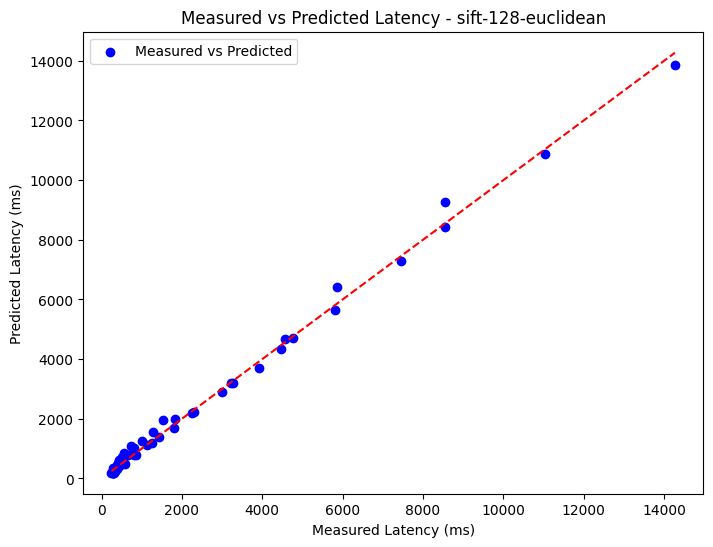

dbname='sift-128-euclidean'
MSE (in ms^2): 27064.24133044696
RMSE (in ms): 164.51213125616894
R2 Score: 0.9959943707444502


112.45251990426168

In [27]:
evaluate_existing_model(localkm_model, X_data,y_data,dbname)

Evaluate on other datasets (don't fit again re-use same model:)

In [ ]:
# dbname = "sift-128-euclidean"
dbname = "lastfm-64-dot"
# dbname = "SIFT10M"
# dbname = "deep-image-96-angular"
# xb, xq, gt, metric = load_dataset("SIFT1M")
xb, xq, gt, metric = load_dataset(dbname)
NUM_THREADS = 16
faiss.omp_set_num_threads(NUM_THREADS)

X_new, y_new =  get_local_kmeans_measurements(xb,xq) # get measurements
evaluate_existing_model(localkm_model, X_new, y_new, dbname) # test existing trained model

In [ ]:
# dbname = "glove-200-angular"
dbname = "SIFT10M"
# dbname = "gist-960-euclidean"
# dbname = "deep-image-96-angular"
# xb, xq, gt, metric = load_dataset("SIFT1M")
xb, xq, gt, metric = load_dataset(dbname)
NUM_THREADS = 16
faiss.omp_set_num_threads(NUM_THREADS)


X_new, y_new =  get_local_kmeans_measurements(xb,xq) # get measurements
evaluate_existing_model(localkm_model, X_new, y_new, dbname) # test existing trained model

Loading Dataset = SIFT10M
Init Index... self.nlist=100 self.niter=0 self.max_pts=256 self.seed=1 self.d=128


## commit reorg with calculating runnign assignments
- `T_commit_reorg = w1 * (N_vis * C_vis * D + Nc) + w2 * ( N_vis*D ) +b`
```
- w1 = 8.912474562983087e-09, w2 = 1.2000867199316712e-06, b = -8.689369633586466
- X1 = N_vis * C_vis * D + Nc
- X2 = N_vis * D 
```

In [18]:
import numpy as np
import time
from tqdm import tqdm

# Assuming the necessary imports and definitions for CrackIVF, metric, xb, xq, etc.
def measure_commit_reorg_for_refine(xb,xq):
    def get_N_visited(index, c_visited_ids):
        N_visited = 0
        D = index.d
        # in case it's multiple
        for cid in c_visited_ids:
            N_visited += index.invlists.list_size(int(cid))
        return N_visited, D

    input_features = []  # To store X1 and X2 for each measurement
    target_variable_y_ms = []  # To store measured latency (T)

    # Iterate over different values of Nc (number of centroids)
    for Nc in [100, 200, 500, 1000, 2000, 5000, 10000, 15000]:
        # Create new index as you vary Nc
        max_pts = 256
        n_iter = 1
        real_crack_index = CrackIVF(
            nlist=Nc, 
            niter=0,
            max_pts=max_pts,  # faiss default
            seed=1,
            metric=metric
        )
        real_crack_index.add(xb)  # Add 1M points to the index
        GLOBAL_CRACKS = real_crack_index.index.reconstruct_n() # centroids # Nc


        # For varying N_crack_locs (number of crack locations)
        num_data_points = 10  # Desired number of data points
        step = max(1, real_crack_index.nlist // num_data_points)  # Ensure step is at least 1

        for C_vis in tqdm(range(1, real_crack_index.nlist, step)):

            # # Take the first N_crack_locs crack locations
            # crack_locations = xq[:N_crack_locs, :]

            # c_visited_ids, c_visited, pids_visited, p_visited = real_crack_index._CrackIVF__get_local_region(crack_locations, 1)
            
            # # get some random assignments
            # RANDOM_running_assignments = np.random.randint(0, real_crack_index.nlist-1, size=pids_visited.shape[0], dtype=int) # if "real"
            # # needed 
            
            real_crack_index.refine_nprobe = C_vis  # Control the number of invlists accessed by ncracks
                
            query = xq[0:1, :] # just get one query and then we vary local region size around it in C_vis
            
            # 1) get local region for C_vis 
            c_visited_ids, c_visited, pids_visited, p_visited = real_crack_index._CrackIVF__get_local_region(query, C_vis)
            
            # Get the number of poitns we run kmeans train N_train
            N_vis, D = get_N_visited(real_crack_index.index, c_visited_ids)
            N_train = min(max_pts*N_vis, N_vis)

            # NOTE: can skip local km for now calculating the comit reorg cost here        
            # local_km = faiss.Kmeans(D, C_vis, niter=n_iter, max_points_per_centroid=max_pts)
            # local_km.train(p_visited) 
            
            # GLOBAL_CRACKS[c_visited_ids] = local_km.centroids # update local cracks
            # refined_global_quantizer = faiss.IndexFlat(D)
            # refined_global_quantizer.add(GLOBAL_CRACKS) # add global cracks no need to add refine
            # len(global cracks )== Nc

            # need to also have the local quantizer...

            local_quantizer = faiss.IndexFlat(real_crack_index.index.d, real_crack_index.metric)
            local_quantizer.add(c_visited) # C_vis <---- local

            print(f"{local_quantizer.ntotal=} == {C_vis=}")
            assert local_quantizer.ntotal == C_vis

            # Get the number of visited points (N_vis) and dimensions (D)
            # measure commit reorg
            start_t = time.perf_counter()
            _, _, _ = real_crack_index._CrackIVF__commit_reorg(
                local_quantizer, #C_vis
                c_visited_ids, #C_vis
                pids_visited, #N_vis
                p_visited, #N_vis
                use_running_assignments=False, # recalculate runnign assignments...
        )
            end_t = time.perf_counter()

            # Get the number of visited points (N_vis) and dimensions (D)
            N_vis, D = get_N_visited(real_crack_index.index, c_visited_ids)
            
            # Store input features and target variable
            X1 = N_vis * C_vis * D + Nc
            X2 = N_vis * D 
            
            # Append to input features and target latency
            input_features.append([X1, X2])
            target_variable_y_ms.append((end_t - start_t) * 1000)  # Latency in milliseconds

    # Convert input features and target variable to np.array
    X_data = np.array(input_features)  # Shape: (num_samples, 2)
    y_data = np.array(target_variable_y_ms)  # Shape: (num_samples, )
    return X_data, y_data
    # Now you can use X_data and y_data in the linear regression model

In [16]:
# Load the dataset
dbname = "sift-128-euclidean"  # Change the dataset name as needed
NUM_THREADS = 16
faiss.omp_set_num_threads(NUM_THREADS)


In [19]:
X_data, y_data = measure_commit_reorg_for_refine(xb,xq)

Init Index... self.nlist=100 self.niter=0 self.max_pts=256 self.seed=1 self.d=128
	---> Index Train Time = 54.8318310175091 ms | Add Time = 396.8567150295712 ms | Assign Time (should be free if C++ implementation )= 255.60553098330274<---


 30%|███       | 3/10 [00:00<00:00, 16.78it/s]

local_quantizer.ntotal=1 == C_vis=1
local_quantizer.ntotal=11 == C_vis=11
local_quantizer.ntotal=21 == C_vis=21
local_quantizer.ntotal=31 == C_vis=31


 50%|█████     | 5/10 [00:00<00:00,  7.81it/s]

local_quantizer.ntotal=41 == C_vis=41
local_quantizer.ntotal=51 == C_vis=51


 70%|███████   | 7/10 [00:01<00:00,  5.80it/s]

local_quantizer.ntotal=61 == C_vis=61


 80%|████████  | 8/10 [00:01<00:00,  5.03it/s]

local_quantizer.ntotal=71 == C_vis=71


 90%|█████████ | 9/10 [00:01<00:00,  4.28it/s]

local_quantizer.ntotal=81 == C_vis=81
local_quantizer.ntotal=91 == C_vis=91


100%|██████████| 10/10 [00:02<00:00,  4.90it/s]


Init Index... self.nlist=200 self.niter=0 self.max_pts=256 self.seed=1 self.d=128
	---> Index Train Time = 61.50443002115935 ms | Add Time = 543.9996909699403 ms | Assign Time (should be free if C++ implementation )= 339.0522829722613<---


  0%|          | 0/10 [00:00<?, ?it/s]

local_quantizer.ntotal=1 == C_vis=1
local_quantizer.ntotal=21 == C_vis=21


 30%|███       | 3/10 [00:00<00:00, 22.18it/s]

local_quantizer.ntotal=41 == C_vis=41
local_quantizer.ntotal=61 == C_vis=61
local_quantizer.ntotal=81 == C_vis=81
local_quantizer.ntotal=101 == C_vis=101


 60%|██████    | 6/10 [00:00<00:00,  8.15it/s]

local_quantizer.ntotal=121 == C_vis=121


 80%|████████  | 8/10 [00:01<00:00,  5.64it/s]

local_quantizer.ntotal=141 == C_vis=141
local_quantizer.ntotal=161 == C_vis=161


 90%|█████████ | 9/10 [00:01<00:00,  4.61it/s]

local_quantizer.ntotal=181 == C_vis=181


100%|██████████| 10/10 [00:02<00:00,  4.94it/s]


Init Index... self.nlist=500 self.niter=0 self.max_pts=256 self.seed=1 self.d=128
	---> Index Train Time = 64.54093102365732 ms | Add Time = 851.2054139864631 ms | Assign Time (should be free if C++ implementation )= 679.8970520030707<---


  0%|          | 0/10 [00:00<?, ?it/s]

local_quantizer.ntotal=1 == C_vis=1


 30%|███       | 3/10 [00:00<00:00, 15.81it/s]

local_quantizer.ntotal=51 == C_vis=51
local_quantizer.ntotal=101 == C_vis=101
local_quantizer.ntotal=151 == C_vis=151
local_quantizer.ntotal=201 == C_vis=201


 50%|█████     | 5/10 [00:00<00:00,  7.15it/s]

local_quantizer.ntotal=251 == C_vis=251


 60%|██████    | 6/10 [00:00<00:00,  5.33it/s]

local_quantizer.ntotal=301 == C_vis=301


 70%|███████   | 7/10 [00:01<00:00,  4.17it/s]

local_quantizer.ntotal=351 == C_vis=351


 80%|████████  | 8/10 [00:01<00:00,  3.28it/s]

local_quantizer.ntotal=401 == C_vis=401


 90%|█████████ | 9/10 [00:02<00:00,  2.58it/s]

local_quantizer.ntotal=451 == C_vis=451


100%|██████████| 10/10 [00:03<00:00,  3.13it/s]


Init Index... self.nlist=1000 self.niter=0 self.max_pts=256 self.seed=1 self.d=128
	---> Index Train Time = 105.96867301501334 ms | Add Time = 1259.725732030347 ms | Assign Time (should be free if C++ implementation )= 1122.1232669777237<---


 20%|██        | 2/10 [00:00<00:00, 17.88it/s]

local_quantizer.ntotal=1 == C_vis=1
local_quantizer.ntotal=101 == C_vis=101
local_quantizer.ntotal=201 == C_vis=201


 40%|████      | 4/10 [00:00<00:00,  7.43it/s]

local_quantizer.ntotal=301 == C_vis=301
local_quantizer.ntotal=401 == C_vis=401
local_quantizer.ntotal=501 == C_vis=501


 60%|██████    | 6/10 [00:01<00:01,  3.69it/s]

local_quantizer.ntotal=601 == C_vis=601


 70%|███████   | 7/10 [00:01<00:01,  2.83it/s]

local_quantizer.ntotal=701 == C_vis=701


 80%|████████  | 8/10 [00:02<00:00,  2.17it/s]

local_quantizer.ntotal=801 == C_vis=801


 90%|█████████ | 9/10 [00:03<00:00,  1.69it/s]

local_quantizer.ntotal=901 == C_vis=901


100%|██████████| 10/10 [00:04<00:00,  2.04it/s]


Init Index... self.nlist=2000 self.niter=0 self.max_pts=256 self.seed=1 self.d=128
	---> Index Train Time = 97.53674996318296 ms | Add Time = 2400.8936699829064 ms | Assign Time (should be free if C++ implementation )= 2281.8348180153407<---


  0%|          | 0/10 [00:00<?, ?it/s]

local_quantizer.ntotal=1 == C_vis=1
local_quantizer.ntotal=201 == C_vis=201
local_quantizer.ntotal=401 == C_vis=401


 30%|███       | 3/10 [00:00<00:00, 10.12it/s]

local_quantizer.ntotal=601 == C_vis=601
local_quantizer.ntotal=801 == C_vis=801


 50%|█████     | 5/10 [00:01<00:01,  3.99it/s]

local_quantizer.ntotal=1001 == C_vis=1001


 60%|██████    | 6/10 [00:01<00:01,  2.64it/s]

local_quantizer.ntotal=1201 == C_vis=1201


 70%|███████   | 7/10 [00:02<00:01,  1.91it/s]

local_quantizer.ntotal=1401 == C_vis=1401


 80%|████████  | 8/10 [00:03<00:01,  1.41it/s]

local_quantizer.ntotal=1601 == C_vis=1601


 90%|█████████ | 9/10 [00:05<00:00,  1.07it/s]

local_quantizer.ntotal=1801 == C_vis=1801


100%|██████████| 10/10 [00:07<00:00,  1.36it/s]


Init Index... self.nlist=5000 self.niter=0 self.max_pts=256 self.seed=1 self.d=128
	---> Index Train Time = 65.7912670285441 ms | Add Time = 5521.950980997644 ms | Assign Time (should be free if C++ implementation )= 5387.491517991293<---


 20%|██        | 2/10 [00:00<00:00, 13.43it/s]

local_quantizer.ntotal=1 == C_vis=1
local_quantizer.ntotal=501 == C_vis=501
local_quantizer.ntotal=1001 == C_vis=1001
local_quantizer.ntotal=1501 == C_vis=1501


 40%|████      | 4/10 [00:01<00:02,  2.95it/s]

local_quantizer.ntotal=2001 == C_vis=2001


 50%|█████     | 5/10 [00:02<00:02,  1.80it/s]

local_quantizer.ntotal=2501 == C_vis=2501


 60%|██████    | 6/10 [00:03<00:03,  1.13it/s]

local_quantizer.ntotal=3001 == C_vis=3001


 70%|███████   | 7/10 [00:05<00:03,  1.23s/it]

local_quantizer.ntotal=3501 == C_vis=3501


 80%|████████  | 8/10 [00:08<00:03,  1.64s/it]

local_quantizer.ntotal=4001 == C_vis=4001


 90%|█████████ | 9/10 [00:12<00:02,  2.27s/it]

local_quantizer.ntotal=4501 == C_vis=4501


100%|██████████| 10/10 [00:17<00:00,  1.71s/it]


Init Index... self.nlist=10000 self.niter=0 self.max_pts=256 self.seed=1 self.d=128
	---> Index Train Time = 57.959650992415845 ms | Add Time = 11901.909217995126 ms | Assign Time (should be free if C++ implementation )= 11719.870853004977<---


  0%|          | 0/10 [00:00<?, ?it/s]

local_quantizer.ntotal=1 == C_vis=1
local_quantizer.ntotal=1001 == C_vis=1001


 20%|██        | 2/10 [00:00<00:00,  9.06it/s]

local_quantizer.ntotal=2001 == C_vis=2001


 30%|███       | 3/10 [00:00<00:02,  3.07it/s]

local_quantizer.ntotal=3001 == C_vis=3001


 40%|████      | 4/10 [00:01<00:03,  1.60it/s]

local_quantizer.ntotal=4001 == C_vis=4001


 50%|█████     | 5/10 [00:03<00:05,  1.11s/it]

local_quantizer.ntotal=5001 == C_vis=5001


 60%|██████    | 6/10 [00:07<00:07,  1.82s/it]

local_quantizer.ntotal=6001 == C_vis=6001


 70%|███████   | 7/10 [00:11<00:07,  2.51s/it]

local_quantizer.ntotal=7001 == C_vis=7001


 80%|████████  | 8/10 [00:16<00:06,  3.35s/it]

local_quantizer.ntotal=8001 == C_vis=8001


 90%|█████████ | 9/10 [00:23<00:04,  4.56s/it]

local_quantizer.ntotal=9001 == C_vis=9001


100%|██████████| 10/10 [00:32<00:00,  3.22s/it]


Init Index... self.nlist=15000 self.niter=0 self.max_pts=256 self.seed=1 self.d=128
	---> Index Train Time = 55.8038370218128 ms | Add Time = 18109.356077038683 ms | Assign Time (should be free if C++ implementation )= 17775.43398598209<---


  0%|          | 0/10 [00:00<?, ?it/s]

local_quantizer.ntotal=1 == C_vis=1
local_quantizer.ntotal=1501 == C_vis=1501


 20%|██        | 2/10 [00:00<00:01,  6.77it/s]

local_quantizer.ntotal=3001 == C_vis=3001


 30%|███       | 3/10 [00:01<00:02,  2.42it/s]

local_quantizer.ntotal=4501 == C_vis=4501


 40%|████      | 4/10 [00:02<00:05,  1.18it/s]

local_quantizer.ntotal=6001 == C_vis=6001


 50%|█████     | 5/10 [00:05<00:07,  1.57s/it]

local_quantizer.ntotal=7501 == C_vis=7501


 60%|██████    | 6/10 [00:10<00:10,  2.53s/it]

local_quantizer.ntotal=9001 == C_vis=9001


 70%|███████   | 7/10 [00:15<00:10,  3.44s/it]

local_quantizer.ntotal=10501 == C_vis=10501


 80%|████████  | 8/10 [00:22<00:09,  4.64s/it]

local_quantizer.ntotal=12001 == C_vis=12001


 90%|█████████ | 9/10 [00:33<00:06,  6.47s/it]

local_quantizer.ntotal=13501 == C_vis=13501


100%|██████████| 10/10 [00:47<00:00,  4.74s/it]


Fitted model: T = w1 * X1 + w2 * X2 + b
w1 = 8.912474562983087e-09, w2 = 1.2000867199316712e-06, b = -8.689369633586466
Mean Absolute Error (MAE): 73.16477176511876 ms


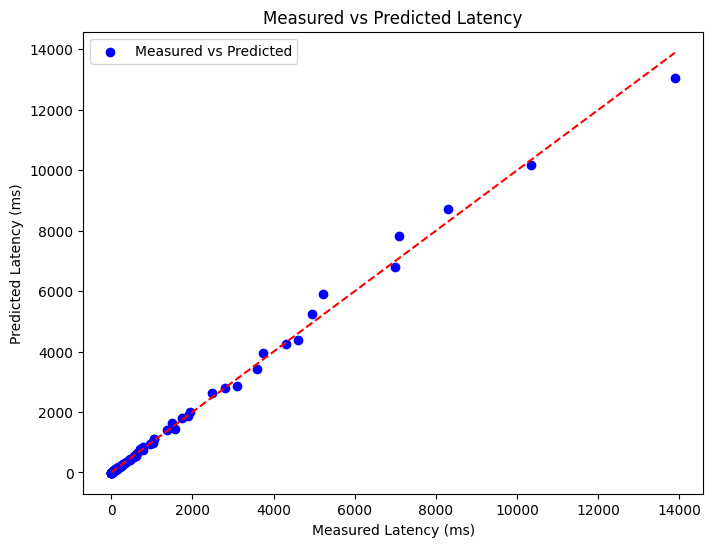

MSE (in ms^2): 28254.48174803881
RMSE (in ms): 168.09069500730493
R2 Score: 0.9953926913104097


8.912474562983087e-09

1.2000867199316712e-06

-8.689369633586466

In [24]:
# X_data = np.array(input_features)  # Shape: (num_samples, 2)
# y_data = np.array(target_variable_y_ms)  # Shape: (num_samples, )

w1, w2, b, mae, localkm_model = fit_and_evaluate_model(X_data, y_data)
w1
w2
b
#w1 = 8.912474562983087e-09, w2 = 1.2000867199316712e-06, b = -8.689369633586466

Test on other datasets:

Loading Dataset = lastfm-64-dot
File already exists at /pub/scratch/vmageirakos/vdb-project-data/data/datasets/lastfm-64-dot.hdf5. Skipping download.
Init Index... self.nlist=100 self.niter=0 self.max_pts=256 self.seed=1 self.d=65
	---> Index Train Time = 11.064436985179782 ms | Add Time = 103.13139704521745 ms | Assign Time (should be free if C++ implementation )= 52.72827099543065<---


  0%|          | 0/10 [00:00<?, ?it/s]

local_quantizer.ntotal=1 == C_vis=1


 70%|███████   | 7/10 [00:00<00:00, 45.68it/s]

local_quantizer.ntotal=11 == C_vis=11
local_quantizer.ntotal=21 == C_vis=21
local_quantizer.ntotal=31 == C_vis=31
local_quantizer.ntotal=41 == C_vis=41
local_quantizer.ntotal=51 == C_vis=51
local_quantizer.ntotal=61 == C_vis=61
local_quantizer.ntotal=71 == C_vis=71


100%|██████████| 10/10 [00:00<00:00, 25.02it/s]

local_quantizer.ntotal=81 == C_vis=81
local_quantizer.ntotal=91 == C_vis=91
Init Index... self.nlist=200 self.niter=0 self.max_pts=256 self.seed=1 self.d=65


	---> Index Train Time = 18.293065018951893 ms | Add Time = 113.78437501844019 ms | Assign Time (should be free if C++ implementation )= 80.93681500758976<---


 70%|███████   | 7/10 [00:00<00:00, 54.31it/s]

local_quantizer.ntotal=1 == C_vis=1
local_quantizer.ntotal=21 == C_vis=21
local_quantizer.ntotal=41 == C_vis=41
local_quantizer.ntotal=61 == C_vis=61
local_quantizer.ntotal=81 == C_vis=81
local_quantizer.ntotal=101 == C_vis=101
local_quantizer.ntotal=121 == C_vis=121
local_quantizer.ntotal=141 == C_vis=141


100%|██████████| 10/10 [00:00<00:00, 26.05it/s]

local_quantizer.ntotal=161 == C_vis=161
local_quantizer.ntotal=181 == C_vis=181
Init Index... self.nlist=500 self.niter=0 self.max_pts=256 self.seed=1 self.d=65


	---> Index Train Time = 25.853772007394582 ms | Add Time = 200.86641103262082 ms | Assign Time (should be free if C++ implementation )= 160.02687497530133<---


 60%|██████    | 6/10 [00:00<00:00, 43.84it/s]

local_quantizer.ntotal=1 == C_vis=1
local_quantizer.ntotal=51 == C_vis=51
local_quantizer.ntotal=101 == C_vis=101
local_quantizer.ntotal=151 == C_vis=151
local_quantizer.ntotal=201 == C_vis=201
local_quantizer.ntotal=251 == C_vis=251
local_quantizer.ntotal=301 == C_vis=301
local_quantizer.ntotal=351 == C_vis=351
local_quantizer.ntotal=401 == C_vis=401


100%|██████████| 10/10 [00:00<00:00, 14.35it/s]

local_quantizer.ntotal=451 == C_vis=451
Init Index... self.nlist=1000 self.niter=0 self.max_pts=256 self.seed=1 self.d=65


	---> Index Train Time = 42.94208995997906 ms | Add Time = 353.3502889913507 ms | Assign Time (should be free if C++ implementation )= 308.58106596861035<---


 50%|█████     | 5/10 [00:00<00:00, 43.77it/s]

local_quantizer.ntotal=1 == C_vis=1
local_quantizer.ntotal=101 == C_vis=101
local_quantizer.ntotal=201 == C_vis=201
local_quantizer.ntotal=301 == C_vis=301
local_quantizer.ntotal=401 == C_vis=401
local_quantizer.ntotal=501 == C_vis=501
local_quantizer.ntotal=601 == C_vis=601
local_quantizer.ntotal=701 == C_vis=701
local_quantizer.ntotal=801 == C_vis=801
local_quantizer.ntotal=901 == C_vis=901


100%|██████████| 10/10 [00:01<00:00,  9.41it/s]


Init Index... self.nlist=2000 self.niter=0 self.max_pts=256 self.seed=1 self.d=65
	---> Index Train Time = 11.28460600739345 ms | Add Time = 657.9647169564851 ms | Assign Time (should be free if C++ implementation )= 600.8955790312029<---


  0%|          | 0/10 [00:00<?, ?it/s]

local_quantizer.ntotal=1 == C_vis=1
local_quantizer.ntotal=201 == C_vis=201
local_quantizer.ntotal=401 == C_vis=401
local_quantizer.ntotal=601 == C_vis=601
local_quantizer.ntotal=801 == C_vis=801


 50%|█████     | 5/10 [00:00<00:00, 26.10it/s]

local_quantizer.ntotal=1001 == C_vis=1001
local_quantizer.ntotal=1201 == C_vis=1201
local_quantizer.ntotal=1401 == C_vis=1401


 80%|████████  | 8/10 [00:00<00:00,  7.50it/s]

local_quantizer.ntotal=1601 == C_vis=1601
local_quantizer.ntotal=1801 == C_vis=1801


100%|██████████| 10/10 [00:01<00:00,  5.24it/s]


Init Index... self.nlist=5000 self.niter=0 self.max_pts=256 self.seed=1 self.d=65
	---> Index Train Time = 9.89099097205326 ms | Add Time = 1573.734451958444 ms | Assign Time (should be free if C++ implementation )= 1469.7392079979181<---


  0%|          | 0/10 [00:00<?, ?it/s]

local_quantizer.ntotal=1 == C_vis=1
local_quantizer.ntotal=501 == C_vis=501
local_quantizer.ntotal=1001 == C_vis=1001
local_quantizer.ntotal=1501 == C_vis=1501


 40%|████      | 4/10 [00:00<00:00, 19.58it/s]

local_quantizer.ntotal=2001 == C_vis=2001
local_quantizer.ntotal=2501 == C_vis=2501


 60%|██████    | 6/10 [00:00<00:00,  6.50it/s]

local_quantizer.ntotal=3001 == C_vis=3001
local_quantizer.ntotal=3501 == C_vis=3501


 80%|████████  | 8/10 [00:02<00:00,  2.85it/s]

local_quantizer.ntotal=4001 == C_vis=4001


 90%|█████████ | 9/10 [00:03<00:00,  2.00it/s]

local_quantizer.ntotal=4501 == C_vis=4501


100%|██████████| 10/10 [00:04<00:00,  2.21it/s]
WARNING clustering 292385 points to 10000 centroids: please provide at least 390000 training points


Init Index... self.nlist=10000 self.niter=0 self.max_pts=256 self.seed=1 self.d=65
	---> Index Train Time = 10.111478972248733 ms | Add Time = 3099.008032993879 ms | Assign Time (should be free if C++ implementation )= 2934.379620011896<---


 30%|███       | 3/10 [00:00<00:00, 18.39it/s]

local_quantizer.ntotal=1 == C_vis=1
local_quantizer.ntotal=1001 == C_vis=1001
local_quantizer.ntotal=2001 == C_vis=2001
local_quantizer.ntotal=3001 == C_vis=3001
local_quantizer.ntotal=4001 == C_vis=4001


 50%|█████     | 5/10 [00:00<00:01,  4.83it/s]

local_quantizer.ntotal=5001 == C_vis=5001


 60%|██████    | 6/10 [00:01<00:01,  2.80it/s]

local_quantizer.ntotal=6001 == C_vis=6001


 70%|███████   | 7/10 [00:02<00:01,  1.70it/s]

local_quantizer.ntotal=7001 == C_vis=7001


 80%|████████  | 8/10 [00:04<00:01,  1.14it/s]

local_quantizer.ntotal=8001 == C_vis=8001


 90%|█████████ | 9/10 [00:06<00:01,  1.23s/it]

local_quantizer.ntotal=9001 == C_vis=9001


100%|██████████| 10/10 [00:09<00:00,  1.08it/s]
WARNING clustering 292385 points to 15000 centroids: please provide at least 585000 training points


Init Index... self.nlist=15000 self.niter=0 self.max_pts=256 self.seed=1 self.d=65
	---> Index Train Time = 35.4319519829005 ms | Add Time = 4731.131288979668 ms | Assign Time (should be free if C++ implementation )= 4814.574446005281<---


  0%|          | 0/10 [00:00<?, ?it/s]

local_quantizer.ntotal=1 == C_vis=1
local_quantizer.ntotal=1501 == C_vis=1501
local_quantizer.ntotal=3001 == C_vis=3001


 30%|███       | 3/10 [00:00<00:00, 13.22it/s]

local_quantizer.ntotal=4501 == C_vis=4501
local_quantizer.ntotal=6001 == C_vis=6001


 50%|█████     | 5/10 [00:01<00:01,  3.30it/s]

local_quantizer.ntotal=7501 == C_vis=7501


 60%|██████    | 6/10 [00:02<00:02,  1.94it/s]

local_quantizer.ntotal=9001 == C_vis=9001


 70%|███████   | 7/10 [00:04<00:02,  1.19it/s]

local_quantizer.ntotal=10501 == C_vis=10501


 80%|████████  | 8/10 [00:06<00:02,  1.27s/it]

local_quantizer.ntotal=12001 == C_vis=12001


 90%|█████████ | 9/10 [00:09<00:01,  1.80s/it]

local_quantizer.ntotal=13501 == C_vis=13501


100%|██████████| 10/10 [00:13<00:00,  1.35s/it]


Mean Absolute Error (MAE) on new dataset: 169.5101655637962 ms


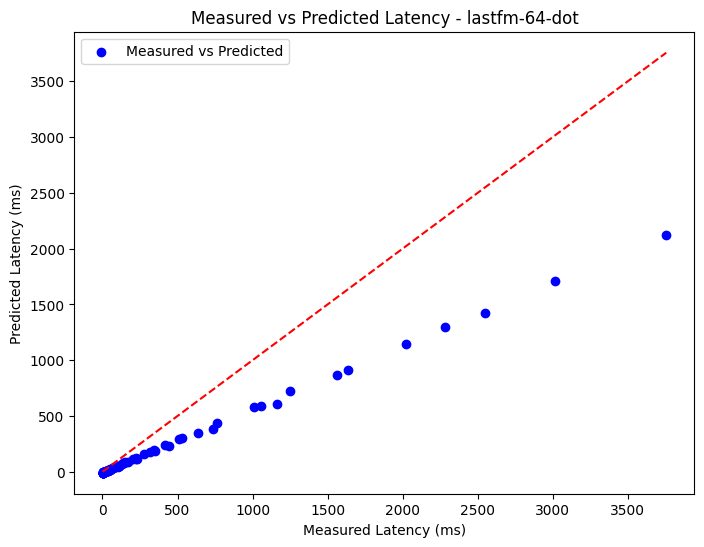

dbname='lastfm-64-dot'
MSE (in ms^2): 125450.58838846251
RMSE (in ms): 354.1900455807059
R2 Score: 0.7568807264517666


169.5101655637962

In [ ]:
# dbname = "sift-128-euclidean"
dbname = "lastfm-64-dot"
# dbname = "SIFT10M"
# dbname = "deep-image-96-angular"
# xb, xq, gt, metric = load_dataset("SIFT1M")
xb, xq, gt, metric = load_dataset(dbname)
NUM_THREADS = 16
faiss.omp_set_num_threads(NUM_THREADS)

X_new, y_new =  measure_commit_reorg_for_refine(xb,xq) # get measurements
evaluate_existing_model(localkm_model, X_new, y_new, dbname) # test existing trained model

Loading Dataset = SIFT10M
Init Index... self.nlist=100 self.niter=0 self.max_pts=256 self.seed=1 self.d=128
	---> Index Train Time = 26206.395159009844 ms | Add Time = 6474.800662021153 ms | Assign Time (should be free if C++ implementation )= 2990.8739490201697<---


 10%|█         | 1/10 [00:00<00:01,  7.63it/s]

local_quantizer.ntotal=1 == C_vis=1
local_quantizer.ntotal=11 == C_vis=11


 20%|██        | 2/10 [00:01<00:04,  1.66it/s]

local_quantizer.ntotal=21 == C_vis=21


 30%|███       | 3/10 [00:02<00:06,  1.06it/s]

local_quantizer.ntotal=31 == C_vis=31


 40%|████      | 4/10 [00:04<00:07,  1.28s/it]

local_quantizer.ntotal=41 == C_vis=41


 50%|█████     | 5/10 [00:06<00:07,  1.59s/it]

local_quantizer.ntotal=51 == C_vis=51


 60%|██████    | 6/10 [00:09<00:08,  2.00s/it]

local_quantizer.ntotal=61 == C_vis=61


 70%|███████   | 7/10 [00:12<00:07,  2.46s/it]

local_quantizer.ntotal=71 == C_vis=71


 80%|████████  | 8/10 [00:16<00:05,  2.91s/it]

local_quantizer.ntotal=81 == C_vis=81


 90%|█████████ | 9/10 [00:20<00:03,  3.43s/it]

local_quantizer.ntotal=91 == C_vis=91


100%|██████████| 10/10 [00:26<00:00,  2.63s/it]


Init Index... self.nlist=200 self.niter=0 self.max_pts=256 self.seed=1 self.d=128
	---> Index Train Time = 1055.4001959972084 ms | Add Time = 6268.551753018983 ms | Assign Time (should be free if C++ implementation )= 3810.2559620165266<---


  0%|          | 0/10 [00:00<?, ?it/s]

local_quantizer.ntotal=1 == C_vis=1
local_quantizer.ntotal=21 == C_vis=21


 20%|██        | 2/10 [00:00<00:02,  2.80it/s]

local_quantizer.ntotal=41 == C_vis=41


 30%|███       | 3/10 [00:01<00:05,  1.40it/s]

local_quantizer.ntotal=61 == C_vis=61


 40%|████      | 4/10 [00:03<00:06,  1.05s/it]

local_quantizer.ntotal=81 == C_vis=81


 50%|█████     | 5/10 [00:05<00:06,  1.35s/it]

local_quantizer.ntotal=101 == C_vis=101


 60%|██████    | 6/10 [00:08<00:07,  1.78s/it]

local_quantizer.ntotal=121 == C_vis=121


 70%|███████   | 7/10 [00:11<00:07,  2.44s/it]

local_quantizer.ntotal=141 == C_vis=141


 80%|████████  | 8/10 [00:16<00:06,  3.06s/it]

local_quantizer.ntotal=161 == C_vis=161


 90%|█████████ | 9/10 [00:21<00:03,  3.73s/it]

local_quantizer.ntotal=181 == C_vis=181


100%|██████████| 10/10 [00:28<00:00,  2.80s/it]


Init Index... self.nlist=500 self.niter=0 self.max_pts=256 self.seed=1 self.d=128
	---> Index Train Time = 1035.9888940001838 ms | Add Time = 9256.777775997762 ms | Assign Time (should be free if C++ implementation )= 7476.966579968575<---


  0%|          | 0/10 [00:00<?, ?it/s]

local_quantizer.ntotal=1 == C_vis=1
local_quantizer.ntotal=51 == C_vis=51


 20%|██        | 2/10 [00:00<00:02,  2.91it/s]

local_quantizer.ntotal=101 == C_vis=101


 30%|███       | 3/10 [00:01<00:04,  1.56it/s]

local_quantizer.ntotal=151 == C_vis=151


 40%|████      | 4/10 [00:03<00:05,  1.01it/s]

local_quantizer.ntotal=201 == C_vis=201


 50%|█████     | 5/10 [00:05<00:06,  1.40s/it]

local_quantizer.ntotal=251 == C_vis=251


 60%|██████    | 6/10 [00:08<00:07,  1.95s/it]

local_quantizer.ntotal=301 == C_vis=301


 70%|███████   | 7/10 [00:12<00:08,  2.74s/it]

local_quantizer.ntotal=351 == C_vis=351


 80%|████████  | 8/10 [00:18<00:07,  3.67s/it]

local_quantizer.ntotal=401 == C_vis=401


 90%|█████████ | 9/10 [00:25<00:04,  4.75s/it]

local_quantizer.ntotal=451 == C_vis=451


100%|██████████| 10/10 [00:34<00:00,  3.43s/it]


Init Index... self.nlist=1000 self.niter=0 self.max_pts=256 self.seed=1 self.d=128
	---> Index Train Time = 1129.493591026403 ms | Add Time = 14514.126162976027 ms | Assign Time (should be free if C++ implementation )= 13406.857812020462<---


  0%|          | 0/10 [00:00<?, ?it/s]

local_quantizer.ntotal=1 == C_vis=1
local_quantizer.ntotal=101 == C_vis=101


 20%|██        | 2/10 [00:00<00:02,  2.97it/s]

local_quantizer.ntotal=201 == C_vis=201


 30%|███       | 3/10 [00:01<00:05,  1.35it/s]

local_quantizer.ntotal=301 == C_vis=301


 40%|████      | 4/10 [00:04<00:07,  1.23s/it]

local_quantizer.ntotal=401 == C_vis=401


 50%|█████     | 5/10 [00:07<00:09,  1.85s/it]

local_quantizer.ntotal=501 == C_vis=501


 60%|██████    | 6/10 [00:11<00:10,  2.69s/it]

local_quantizer.ntotal=601 == C_vis=601


 70%|███████   | 7/10 [00:18<00:12,  4.03s/it]

local_quantizer.ntotal=701 == C_vis=701


 80%|████████  | 8/10 [00:27<00:11,  5.53s/it]

local_quantizer.ntotal=801 == C_vis=801


 90%|█████████ | 9/10 [00:38<00:07,  7.27s/it]

local_quantizer.ntotal=901 == C_vis=901


100%|██████████| 10/10 [00:51<00:00,  5.16s/it]


Init Index... self.nlist=2000 self.niter=0 self.max_pts=256 self.seed=1 self.d=128
	---> Index Train Time = 1194.4378180196509 ms | Add Time = 26898.066263995133 ms | Assign Time (should be free if C++ implementation )= 22467.455060977954<---


  0%|          | 0/10 [00:00<?, ?it/s]

local_quantizer.ntotal=1 == C_vis=1
local_quantizer.ntotal=201 == C_vis=201


 20%|██        | 2/10 [00:00<00:03,  2.51it/s]

local_quantizer.ntotal=401 == C_vis=401


 30%|███       | 3/10 [00:02<00:06,  1.07it/s]

local_quantizer.ntotal=601 == C_vis=601


 40%|████      | 4/10 [00:05<00:10,  1.69s/it]

local_quantizer.ntotal=801 == C_vis=801


 50%|█████     | 5/10 [00:10<00:13,  2.75s/it]

local_quantizer.ntotal=1001 == C_vis=1001


 60%|██████    | 6/10 [00:17<00:16,  4.13s/it]

local_quantizer.ntotal=1201 == C_vis=1201


 70%|███████   | 7/10 [00:27<00:18,  6.28s/it]

local_quantizer.ntotal=1401 == C_vis=1401


 80%|████████  | 8/10 [00:41<00:17,  8.72s/it]

local_quantizer.ntotal=1601 == C_vis=1601


 90%|█████████ | 9/10 [00:58<00:11, 11.17s/it]

local_quantizer.ntotal=1801 == C_vis=1801


100%|██████████| 10/10 [01:20<00:00,  8.06s/it]


Init Index... self.nlist=5000 self.niter=0 self.max_pts=256 self.seed=1 self.d=128
	---> Index Train Time = 1435.499929008074 ms | Add Time = 59976.004918979015 ms | Assign Time (should be free if C++ implementation )= 59249.508507025894<---


  0%|          | 0/10 [00:00<?, ?it/s]

local_quantizer.ntotal=1 == C_vis=1
local_quantizer.ntotal=501 == C_vis=501


 20%|██        | 2/10 [00:01<00:04,  1.76it/s]

local_quantizer.ntotal=1001 == C_vis=1001


 30%|███       | 3/10 [00:04<00:11,  1.58s/it]

local_quantizer.ntotal=1501 == C_vis=1501


 40%|████      | 4/10 [00:09<00:18,  3.07s/it]

local_quantizer.ntotal=2001 == C_vis=2001


 50%|█████     | 5/10 [00:18<00:25,  5.18s/it]

local_quantizer.ntotal=2501 == C_vis=2501


 60%|██████    | 6/10 [00:33<00:33,  8.26s/it]

local_quantizer.ntotal=3001 == C_vis=3001


 70%|███████   | 7/10 [00:54<00:37, 12.36s/it]

local_quantizer.ntotal=3501 == C_vis=3501


 80%|████████  | 8/10 [01:20<00:33, 16.86s/it]

local_quantizer.ntotal=4001 == C_vis=4001


 90%|█████████ | 9/10 [01:55<00:22, 22.25s/it]

local_quantizer.ntotal=4501 == C_vis=4501


100%|██████████| 10/10 [02:53<00:00, 17.35s/it]


Init Index... self.nlist=10000 self.niter=0 self.max_pts=256 self.seed=1 self.d=128
	---> Index Train Time = 2888.9473829767667 ms | Add Time = 125839.64501699666 ms | Assign Time (should be free if C++ implementation )= 118408.93358801259<---


  0%|          | 0/10 [00:00<?, ?it/s]

local_quantizer.ntotal=1 == C_vis=1
local_quantizer.ntotal=1001 == C_vis=1001


 20%|██        | 2/10 [00:01<00:06,  1.33it/s]

local_quantizer.ntotal=2001 == C_vis=2001


 30%|███       | 3/10 [00:06<00:17,  2.50s/it]

local_quantizer.ntotal=3001 == C_vis=3001


 40%|████      | 4/10 [00:16<00:31,  5.19s/it]

local_quantizer.ntotal=4001 == C_vis=4001


 50%|█████     | 5/10 [00:34<00:48,  9.67s/it]

local_quantizer.ntotal=5001 == C_vis=5001


 60%|██████    | 6/10 [01:00<01:00, 15.02s/it]

local_quantizer.ntotal=6001 == C_vis=6001


 70%|███████   | 7/10 [01:40<01:09, 23.33s/it]

local_quantizer.ntotal=7001 == C_vis=7001


 80%|████████  | 8/10 [02:29<01:02, 31.43s/it]

local_quantizer.ntotal=8001 == C_vis=8001


 90%|█████████ | 9/10 [03:34<00:41, 41.70s/it]

local_quantizer.ntotal=9001 == C_vis=9001


100%|██████████| 10/10 [05:08<00:00, 30.90s/it]


Init Index... self.nlist=15000 self.niter=0 self.max_pts=256 self.seed=1 self.d=128
	---> Index Train Time = 3970.137830998283 ms | Add Time = 191480.75467103627 ms | Assign Time (should be free if C++ implementation )= 181774.4309679838<---


  0%|          | 0/10 [00:00<?, ?it/s]

local_quantizer.ntotal=1 == C_vis=1
local_quantizer.ntotal=1501 == C_vis=1501


 20%|██        | 2/10 [00:02<00:08,  1.11s/it]

local_quantizer.ntotal=3001 == C_vis=3001


 30%|███       | 3/10 [00:09<00:24,  3.56s/it]

local_quantizer.ntotal=4501 == C_vis=4501


 40%|████      | 4/10 [00:23<00:44,  7.41s/it]

local_quantizer.ntotal=6001 == C_vis=6001


 50%|█████     | 5/10 [00:49<01:10, 14.09s/it]

local_quantizer.ntotal=7501 == C_vis=7501


 60%|██████    | 6/10 [01:33<01:35, 23.80s/it]

local_quantizer.ntotal=9001 == C_vis=9001


 70%|███████   | 7/10 [02:27<01:40, 33.64s/it]

local_quantizer.ntotal=10501 == C_vis=10501


 80%|████████  | 8/10 [03:44<01:34, 47.43s/it]

local_quantizer.ntotal=12001 == C_vis=12001


 90%|█████████ | 9/10 [05:29<01:05, 65.17s/it]

local_quantizer.ntotal=13501 == C_vis=13501


100%|██████████| 10/10 [07:49<00:00, 46.94s/it]


Mean Absolute Error (MAE) on new dataset: 642.2592157864101 ms


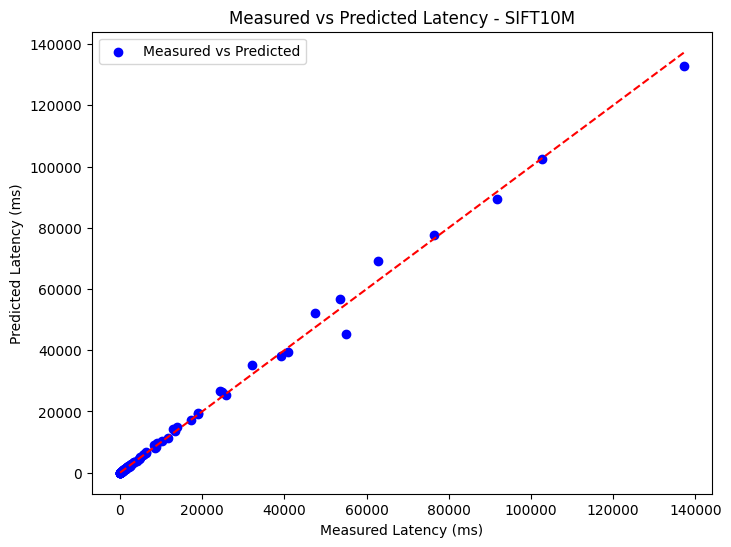

dbname='SIFT10M'
MSE (in ms^2): 2739403.911519199
RMSE (in ms): 1655.1144708204322
R2 Score: 0.995622325516889


642.2592157864101

In [27]:
dbname = "SIFT10M"
# dbname = "gist-960-euclidean"
# dbname = "deep-image-96-angular"
# xb, xq, gt, metric = load_dataset("SIFT1M")
xb, xq, gt, metric = load_dataset(dbname)
NUM_THREADS = 16
faiss.omp_set_num_threads(NUM_THREADS)

X_new, y_new =  measure_commit_reorg_for_refine(xb,xq) # get measurements
evaluate_existing_model(localkm_model, X_new, y_new, dbname) # test existing trained model

Loading Dataset = deep-image-96-angular
File already exists at /pub/scratch/vmageirakos/vdb-project-data/data/datasets/deep-image-96-angular.hdf5. Skipping download.
Init Index... self.nlist=100 self.niter=0 self.max_pts=256 self.seed=1 self.d=96
	---> Index Train Time = 424.4381469907239 ms | Add Time = 3757.158654043451 ms | Assign Time (should be free if C++ implementation )= 1916.4187359856442<---


 10%|█         | 1/10 [00:00<00:01,  5.99it/s]

local_quantizer.ntotal=1 == C_vis=1
local_quantizer.ntotal=11 == C_vis=11


 20%|██        | 2/10 [00:00<00:03,  2.61it/s]

local_quantizer.ntotal=21 == C_vis=21


 30%|███       | 3/10 [00:01<00:04,  1.70it/s]

local_quantizer.ntotal=31 == C_vis=31


 40%|████      | 4/10 [00:02<00:05,  1.16it/s]

local_quantizer.ntotal=41 == C_vis=41


 50%|█████     | 5/10 [00:04<00:05,  1.09s/it]

local_quantizer.ntotal=51 == C_vis=51


 60%|██████    | 6/10 [00:05<00:04,  1.25s/it]

local_quantizer.ntotal=61 == C_vis=61


 70%|███████   | 7/10 [00:08<00:04,  1.54s/it]

local_quantizer.ntotal=71 == C_vis=71


 80%|████████  | 8/10 [00:10<00:03,  1.76s/it]

local_quantizer.ntotal=81 == C_vis=81


 90%|█████████ | 9/10 [00:12<00:02,  2.06s/it]

local_quantizer.ntotal=91 == C_vis=91


100%|██████████| 10/10 [00:16<00:00,  1.62s/it]


Init Index... self.nlist=200 self.niter=0 self.max_pts=256 self.seed=1 self.d=96
	---> Index Train Time = 417.71693603368476 ms | Add Time = 4365.185739996377 ms | Assign Time (should be free if C++ implementation )= 2830.908512987662<---


  0%|          | 0/10 [00:00<?, ?it/s]

local_quantizer.ntotal=1 == C_vis=1
local_quantizer.ntotal=21 == C_vis=21


 20%|██        | 2/10 [00:00<00:01,  5.39it/s]

local_quantizer.ntotal=41 == C_vis=41


 30%|███       | 3/10 [00:00<00:02,  2.91it/s]

local_quantizer.ntotal=61 == C_vis=61


 40%|████      | 4/10 [00:01<00:03,  1.74it/s]

local_quantizer.ntotal=81 == C_vis=81


 50%|█████     | 5/10 [00:03<00:04,  1.15it/s]

local_quantizer.ntotal=101 == C_vis=101


 60%|██████    | 6/10 [00:05<00:04,  1.20s/it]

local_quantizer.ntotal=121 == C_vis=121


 70%|███████   | 7/10 [00:07<00:04,  1.56s/it]

local_quantizer.ntotal=141 == C_vis=141


 80%|████████  | 8/10 [00:10<00:03,  1.95s/it]

local_quantizer.ntotal=161 == C_vis=161


 90%|█████████ | 9/10 [00:13<00:02,  2.35s/it]

local_quantizer.ntotal=181 == C_vis=181


100%|██████████| 10/10 [00:17<00:00,  1.75s/it]


Init Index... self.nlist=500 self.niter=0 self.max_pts=256 self.seed=1 self.d=96
	---> Index Train Time = 453.9133720099926 ms | Add Time = 7476.802442979533 ms | Assign Time (should be free if C++ implementation )= 6143.95857200725<---


  0%|          | 0/10 [00:00<?, ?it/s]

local_quantizer.ntotal=1 == C_vis=1
local_quantizer.ntotal=51 == C_vis=51


 20%|██        | 2/10 [00:00<00:01,  4.05it/s]

local_quantizer.ntotal=101 == C_vis=101


 30%|███       | 3/10 [00:01<00:03,  1.98it/s]

local_quantizer.ntotal=151 == C_vis=151


 40%|████      | 4/10 [00:02<00:04,  1.29it/s]

local_quantizer.ntotal=201 == C_vis=201


 50%|█████     | 5/10 [00:04<00:05,  1.18s/it]

local_quantizer.ntotal=251 == C_vis=251


 60%|██████    | 6/10 [00:07<00:06,  1.69s/it]

local_quantizer.ntotal=301 == C_vis=301


 70%|███████   | 7/10 [00:10<00:06,  2.25s/it]

local_quantizer.ntotal=351 == C_vis=351


 80%|████████  | 8/10 [00:14<00:05,  2.89s/it]

local_quantizer.ntotal=401 == C_vis=401


 90%|█████████ | 9/10 [00:20<00:03,  3.72s/it]

local_quantizer.ntotal=451 == C_vis=451


100%|██████████| 10/10 [00:26<00:00,  2.69s/it]


Init Index... self.nlist=1000 self.niter=0 self.max_pts=256 self.seed=1 self.d=96
	---> Index Train Time = 446.53245102381334 ms | Add Time = 10618.564959964715 ms | Assign Time (should be free if C++ implementation )= 11114.16985100368<---


  0%|          | 0/10 [00:00<?, ?it/s]

local_quantizer.ntotal=1 == C_vis=1
local_quantizer.ntotal=101 == C_vis=101


 20%|██        | 2/10 [00:00<00:01,  5.20it/s]

local_quantizer.ntotal=201 == C_vis=201


 30%|███       | 3/10 [00:01<00:03,  2.03it/s]

local_quantizer.ntotal=301 == C_vis=301


 40%|████      | 4/10 [00:02<00:05,  1.09it/s]

local_quantizer.ntotal=401 == C_vis=401


 50%|█████     | 5/10 [00:05<00:07,  1.56s/it]

local_quantizer.ntotal=501 == C_vis=501


 60%|██████    | 6/10 [00:09<00:09,  2.36s/it]

local_quantizer.ntotal=601 == C_vis=601


 70%|███████   | 7/10 [00:15<00:10,  3.37s/it]

local_quantizer.ntotal=701 == C_vis=701


 80%|████████  | 8/10 [00:22<00:09,  4.54s/it]

local_quantizer.ntotal=801 == C_vis=801


 90%|█████████ | 9/10 [00:30<00:05,  5.80s/it]

local_quantizer.ntotal=901 == C_vis=901


100%|██████████| 10/10 [00:41<00:00,  4.15s/it]


Init Index... self.nlist=2000 self.niter=0 self.max_pts=256 self.seed=1 self.d=96
	---> Index Train Time = 509.1962890001014 ms | Add Time = 20185.924420016818 ms | Assign Time (should be free if C++ implementation )= 19305.688561988063<---


  0%|          | 0/10 [00:00<?, ?it/s]

local_quantizer.ntotal=1 == C_vis=1
local_quantizer.ntotal=201 == C_vis=201


 20%|██        | 2/10 [00:00<00:02,  3.05it/s]

local_quantizer.ntotal=401 == C_vis=401


 30%|███       | 3/10 [00:02<00:06,  1.17it/s]

local_quantizer.ntotal=601 == C_vis=601


 40%|████      | 4/10 [00:05<00:09,  1.62s/it]

local_quantizer.ntotal=801 == C_vis=801


 50%|█████     | 5/10 [00:09<00:13,  2.65s/it]

local_quantizer.ntotal=1001 == C_vis=1001


 60%|██████    | 6/10 [00:16<00:15,  3.89s/it]

local_quantizer.ntotal=1201 == C_vis=1201


 70%|███████   | 7/10 [00:25<00:16,  5.53s/it]

local_quantizer.ntotal=1401 == C_vis=1401


 80%|████████  | 8/10 [00:36<00:14,  7.47s/it]

local_quantizer.ntotal=1601 == C_vis=1601


 90%|█████████ | 9/10 [00:52<00:10, 10.07s/it]

local_quantizer.ntotal=1801 == C_vis=1801


100%|██████████| 10/10 [01:11<00:00,  7.12s/it]


Init Index... self.nlist=5000 self.niter=0 self.max_pts=256 self.seed=1 self.d=96
	---> Index Train Time = 533.2759800367057 ms | Add Time = 49292.094212025404 ms | Assign Time (should be free if C++ implementation )= 48548.5964549589<---


  0%|          | 0/10 [00:00<?, ?it/s]

local_quantizer.ntotal=1 == C_vis=1
local_quantizer.ntotal=501 == C_vis=501


 20%|██        | 2/10 [00:01<00:04,  1.79it/s]

local_quantizer.ntotal=1001 == C_vis=1001


 30%|███       | 3/10 [00:04<00:11,  1.58s/it]

local_quantizer.ntotal=1501 == C_vis=1501


 40%|████      | 4/10 [00:10<00:19,  3.25s/it]

local_quantizer.ntotal=2001 == C_vis=2001


 50%|█████     | 5/10 [00:19<00:26,  5.37s/it]

local_quantizer.ntotal=2501 == C_vis=2501


 60%|██████    | 6/10 [00:34<00:34,  8.58s/it]

local_quantizer.ntotal=3001 == C_vis=3001


 70%|███████   | 7/10 [00:56<00:38, 12.78s/it]

local_quantizer.ntotal=3501 == C_vis=3501


 80%|████████  | 8/10 [01:22<00:33, 16.92s/it]

local_quantizer.ntotal=4001 == C_vis=4001


 90%|█████████ | 9/10 [01:58<00:23, 23.02s/it]

local_quantizer.ntotal=4501 == C_vis=4501


100%|██████████| 10/10 [02:39<00:00, 15.91s/it]


Init Index... self.nlist=10000 self.niter=0 self.max_pts=256 self.seed=1 self.d=96
	---> Index Train Time = 584.4528300222009 ms | Add Time = 96520.68589703413 ms | Assign Time (should be free if C++ implementation )= 93889.72975302022<---


  0%|          | 0/10 [00:00<?, ?it/s]

local_quantizer.ntotal=1 == C_vis=1
local_quantizer.ntotal=1001 == C_vis=1001


 20%|██        | 2/10 [00:01<00:06,  1.16it/s]

local_quantizer.ntotal=2001 == C_vis=2001


 30%|███       | 3/10 [00:07<00:19,  2.74s/it]

local_quantizer.ntotal=3001 == C_vis=3001


 40%|████      | 4/10 [00:17<00:33,  5.59s/it]

local_quantizer.ntotal=4001 == C_vis=4001


 50%|█████     | 5/10 [00:36<00:51, 10.21s/it]

local_quantizer.ntotal=5001 == C_vis=5001


 60%|██████    | 6/10 [01:05<01:05, 16.42s/it]

local_quantizer.ntotal=6001 == C_vis=6001


 70%|███████   | 7/10 [01:41<01:08, 22.78s/it]

local_quantizer.ntotal=7001 == C_vis=7001


 80%|████████  | 8/10 [02:35<01:05, 32.54s/it]

local_quantizer.ntotal=8001 == C_vis=8001


 90%|█████████ | 9/10 [03:45<00:44, 44.15s/it]

local_quantizer.ntotal=9001 == C_vis=9001


100%|██████████| 10/10 [05:02<00:00, 30.21s/it]


Init Index... self.nlist=15000 self.niter=0 self.max_pts=256 self.seed=1 self.d=96
	---> Index Train Time = 1012.5099929864518 ms | Add Time = 138425.2049670322 ms | Assign Time (should be free if C++ implementation )= 140171.8911419739<---


  0%|          | 0/10 [00:00<?, ?it/s]

local_quantizer.ntotal=1 == C_vis=1
local_quantizer.ntotal=1501 == C_vis=1501


 20%|██        | 2/10 [00:02<00:09,  1.14s/it]

local_quantizer.ntotal=3001 == C_vis=3001


 30%|███       | 3/10 [00:09<00:24,  3.52s/it]

local_quantizer.ntotal=4501 == C_vis=4501


 40%|████      | 4/10 [00:23<00:45,  7.60s/it]

local_quantizer.ntotal=6001 == C_vis=6001


 50%|█████     | 5/10 [00:51<01:13, 14.68s/it]

local_quantizer.ntotal=7501 == C_vis=7501


 60%|██████    | 6/10 [01:29<01:29, 22.28s/it]

local_quantizer.ntotal=9001 == C_vis=9001


 70%|███████   | 7/10 [02:30<01:44, 34.78s/it]

local_quantizer.ntotal=10501 == C_vis=10501


 80%|████████  | 8/10 [03:42<01:33, 46.67s/it]

local_quantizer.ntotal=12001 == C_vis=12001


 90%|█████████ | 9/10 [05:12<01:00, 60.03s/it]

local_quantizer.ntotal=13501 == C_vis=13501


100%|██████████| 10/10 [07:28<00:00, 44.87s/it]


Mean Absolute Error (MAE) on new dataset: 1846.219606720841 ms


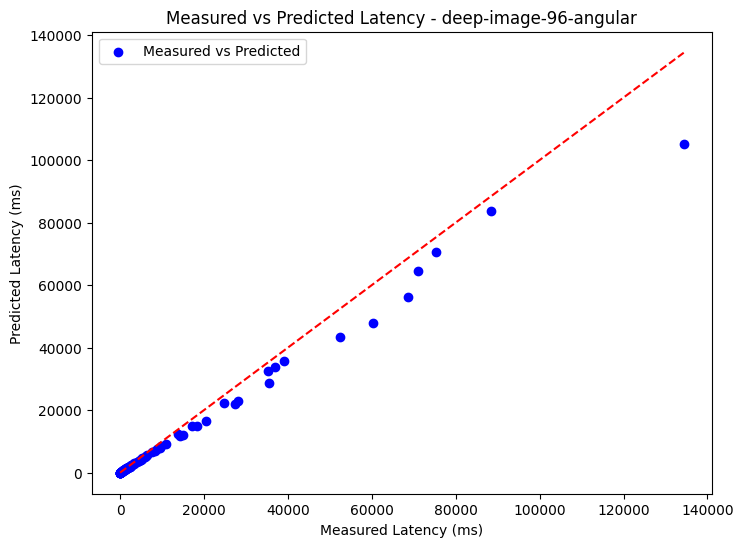

dbname='deep-image-96-angular'
MSE (in ms^2): 19305610.639655314
RMSE (in ms): 4393.8150438605535
R2 Score: 0.9653038356940611


1846.219606720841

In [29]:
dbname = "deep-image-96-angular"
# xb, xq, gt, metric = load_dataset("SIFT1M")
xb, xq, gt, metric = load_dataset(dbname)
NUM_THREADS = 16
faiss.omp_set_num_threads(NUM_THREADS)

X_new, y_new =  measure_commit_reorg_for_refine(xb,xq) # get measurements
evaluate_existing_model(localkm_model, X_new, y_new, dbname) # test existing trained model


## REFINE: Putting it together (nthreads=16)

- `T_refine =` T_get_local_region(`SKIPED`) + T_local_kmeans + T_commit_reorg <-----
- T_get_local_region : 
    - `TODO: SEE EFFECT - SKIPED THIS ONE`
- T_local_kmeans :
    - `X1 = n_iter * N_train * C_vis * D, X2 = Nc * D`
    - `w1 = 9.311884586956287e-09, w2 = 7.437262586898243e-05, b = 191.62760060405162`
- T_commit_reorg:
    - `X1 = N_vis * C_vis * D + Nc, X2 = N_vis * D`
    - `w1 = 8.912474562983087e-09, w2 = 1.2000867199316712e-06, b = -8.689369633586466`


In [ ]:
def __refine_cost_estimate_get_local_region(N_crack_locs, Nc, N_vis, D):
    # NOTE: Can I re-use this for REFINE? 
    # NOTE: N_crack_locs is like num queries, I think it's 1 for local refine
    X1, X2 = N_crack_locs * Nc, N_vis * D
    # w1, w2, b = 9.792029439425269e-07, 8.848264329863606e-07, 3.587780694965886
    w1,w2, b = 0,0,0
    return w1*X1 + w2*X2 + b

def __refine_cost_estimate_commit_reorg(Nc, N_vis, C_vis, D):
    # NOTE: Nc comes from compute bincount which is across all centroids
    X1, X2 = N_vis * C_vis * D + Nc, N_vis * D
    w1, w2, b = 8.912474562983087e-09, 1.2000867199316712e-06, -8.689369633586466
    return w1*X1 + w2*X2 + b

def __refine_cost_estimate_local_kmeans(N_vis, max_pts, n_iter, C_vis, D, Nc):
    N_train = min(N_vis, max_pts * N_vis)
    X1, X2 = n_iter * N_train * C_vis * D, Nc * D
    w1, w2, b = 9.311884586956287e-09, 7.437262586898243e-05, 191.62760060405162
    return w1*X1 + w2*X2 + b

def get_cost_estimate_refine(N_crack_locs, Nc, N_vis, D, N, max_pts, n_iter, C_vis):
    # assert nthreads == 16 # because we hardcoded for 16 threads
    T_get_local_region = __refine_cost_estimate_get_local_region(N_crack_locs, Nc, N_vis, D)
    T_local_kmeans = __refine_cost_estimate_local_kmeans(N_vis, max_pts, n_iter, C_vis, D, Nc)
    T_commit_reorg = __refine_cost_estimate_commit_reorg(Nc, N_vis, C_vis, D)
    return T_get_local_region + T_commit_reorg + T_local_kmeans
